### This code provides a function that takes a dataframe of features and a target as an input, and gives the prdictions, feature ranking and a plot of true vs predicted values as an output


In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 


#### <font color='violet'> ML modelling with 33 galaxy and halo features; df from v5 used here



In [2]:
# df here read from the data filtered file from notebook v5
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

### <font color='violet'> 1. Size, Mass and Halo Spin plot




##### For this part of the code, I need log of GalpropMstar and log of GalpropHalfRadius in order to make the plot. However, since I drop GalpropMstar from the df immediately after normalization, I should plot it first thing here. For a reference to this plot, see notebook v5 with the same title.

In [3]:
mass_size_corr = round(stats.spearmanr(df_log_mass_filtered_v5['GalpropLogMstar'], 
                                               df_log_mass_filtered_v5['GalpropLogHalfRadius'])[0], 2)
SFR_size_corr = round(stats.spearmanr(df_log_mass_filtered_v5['GalpropLogSfr'], 
                                              df_log_mass_filtered_v5['GalpropLogHalfRadius'] )[0], 2)
SFR_mass_corr = round(stats.spearmanr(df_log_mass_filtered_v5['GalpropLogSfr'], 
                                              df_log_mass_filtered_v5['GalpropLogMstar'] )[0], 2)
mom_size_corr = round(stats.spearmanr(df_log_mass_filtered_v5['HalopropSpin'], 
                                              df_log_mass_filtered_v5['GalpropLogHalfRadius'])[0], 2)



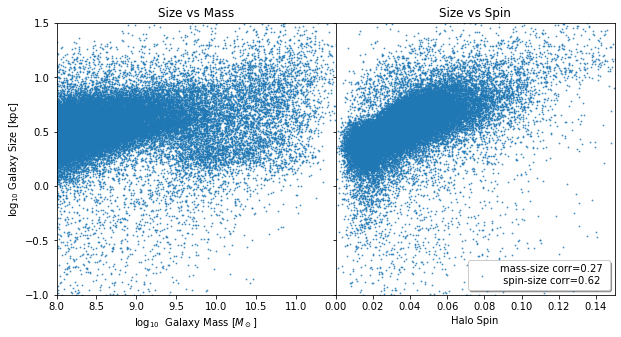

In [4]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
# fig.suptitle('TNG-SAM Central Galaxies: Size, Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_log_mass_filtered_v5['GalpropLogMstar'], df_log_mass_filtered_v5['GalpropLogHalfRadius'], 
                    s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)

ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([-1.0,1.5])
ax1.set_title('Size vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $ Galaxy Size [kpc] ')
# ax1.legend(loc='lower right', shadow=True)


label = 'mass-size corr={} \n spin-size corr={}'.format(mass_size_corr, mom_size_corr )
im2 = ax2.scatter(df_log_mass_filtered_v5['HalopropSpin'], df_log_mass_filtered_v5['GalpropLogHalfRadius'], 
                     s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)

ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SAM_centrals_Mass_Size_AngMom_v5_log.jpeg", dpi=500)
plt.show()

### Drop the columns not needed (see explanations in related doc 'TNG-SAM 33-feature analysis')

In [5]:
df_log_mass_filtered=df_log_mass_filtered_v5.drop(columns =['GalpropRedshift', 
                                               'GalpropRfric', 'HalopropMaccdot_metal', 'HalopropMaccdot_pristine',
                                               'HalopropMaccdot_reaccreate_metal', 'HalopropMcooldot',
                                               'HalopropMdot_eject', 'HalopropMdot_eject_metal',
                                               'GalpropX', 'GalpropVx','GalpropY', 'GalpropVy',
                                               'GalpropZ', 'GalpropVz', 'GalpropTsat',
                                               'GalpropLogMstar', 'GalpropLogHalfRadius', 'GalpropLogMvir',
                                               'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr',
                                               'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
                                               'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass',
                                               'Galprop_baryon_mass', 'Galprop_gas_fraction',
                                               'GalpropRbulge',  'GalpropRdisk', 'GalpropMvir', 'GalpropMstrip'])

## 2. Normalization of dataset

### Normalize SigmaBulge and Vdisk by Vvir


In [6]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

In [7]:
# Define Halo property Vvir (as it does not exist in the dataset above)
v= Mvir_to_Vvir (np.array(df_log_mass_filtered.loc[:,'HalopropMvir']),0) # has units

In [8]:
# add Halo property Vvir
df_log_mass_filtered.loc[:, 'HalopropVvir']=v.value # shape of df at this point: df_log_mass_filtered.shape (35390, 36)

### Normalize the dataset by dividing masses by Mhalo and size by Rhalo

In [9]:
def normalization_func(df):
    '''
    Normalizes the dataset by dividing all masses by halo mass, and galaxy size by halo size

    '''
#     could also use the method below
#     df_log_mass_filtered.loc[:,'GalpropNormMstar']=df_log_mass_filtered.loc[:,'GalpropMstar'].div(df_log_mass_filtered.HalopropMvir, axis=0)
    
    halomass=df.loc[:,'HalopropMvir']
    halorad= df.loc[:,'GalpropRhalo']
    
    df.loc[:,'GalpropNormHalfRadius']=df.loc[:,'GalpropHalfRadius']/halorad
    df.loc[:,'GalpropNormRhalo']=df.loc[:,'GalpropRhalo']/halorad

    df.loc[:,'GalpropNormMstar']=df.loc[:,'GalpropMstar']/halomass
#     df.loc[:,'GalpropNormMvir']=df.loc[:,'GalpropMvir']/halomass
    df.loc[:,'HalopropNormMhot']=df.loc[:,'HalopropMhot']/halomass
    df.loc[:,'GalpropNormMbulge']=df.loc[:,'GalpropMbulge']/halomass
    
    df.loc[:,'GalpropNormMBH']=df.loc[:,'GalpropMBH']/halomass
    df.loc[:,'GalpropNormMH2']=df.loc[:,'GalpropMH2']/halomass
    df.loc[:,'GalpropNormMHI']=df.loc[:,'GalpropMHI']/halomass
    df.loc[:,'GalpropNormMHII']=df.loc[:,'GalpropMHII']/halomass
    df.loc[:,'GalpropNormMcold']=df.loc[:,'GalpropMcold']/halomass
    df.loc[:,'GalpropNormMstar_merge']=df.loc[:,'GalpropMstar_merge']/halomass
#     df.loc[:,'GalpropNormMstrip']=df.loc[:,'GalpropMstrip']/halomass
    
    df.loc[:,'HalopropNormMass_ejected']=df.loc[:,'HalopropMass_ejected']/halomass
    df.loc[:,'HalopropNormMstar_diffuse']=df.loc[:,'HalopropMstar_diffuse']/halomass
    df.loc[:,'HalopropNormMvir']=df.loc[:,'HalopropMvir']/halomass
    
    df.loc[:,'GalpropNormSigmaBulge']=df.loc[:,'GalpropSigmaBulge']/df.loc[:,'HalopropVvir']
    df.loc[:,'GalpropNormVdisk']=df.loc[:,'GalpropVdisk']/df.loc[:,'HalopropVvir']
    
    return df

In [10]:
df_normalized=normalization_func(df_log_mass_filtered) # where shape is: df_normalized.shape=(35390, 52)

In [11]:
# drop the original columns of normalized features + columns used for normalization
df_normalized=df_normalized.drop(columns=['GalpropHalfRadius',  'GalpropMstar',
 'HalopropMhot','GalpropMbulge','GalpropMBH','GalpropMH2','GalpropMHI','GalpropMHII',
 'GalpropMcold','GalpropMstar_merge','HalopropMass_ejected',
 'HalopropMstar_diffuse','HalopropMvir', 'HalopropNormMvir', 'GalpropRhalo','GalpropNormRhalo', 'HalopropVvir',
                                        'GalpropSigmaBulge', 'GalpropVdisk' ])
# df shape now is: df_normalized.shape =(35390, 33)

##### GalpropMaccdot is 99% zeros, so we remove it from the dataset (hence, we have a 31-feature dataset) for futureanalysis. However, for the analysis below we keep the old 33-feat. dataset in order to be able to compare new results with old ones.

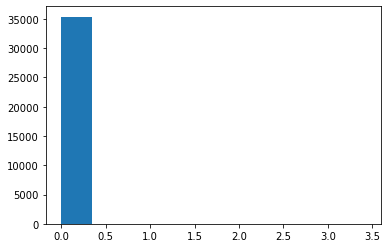

In [14]:
plt.hist(df_normalized['GalpropMaccdot'])
plt.show()

In [15]:
df_normalized_31=df_normalized.drop(columns=['GalpropMaccdot'])

In [17]:
df_normalized_31.shape # 31 referring to the features, as one is the target (galaxy sizes)

(35390, 32)

In [18]:
#  df_normalized_31.to_csv('Halo Mass Normalized Dataset w 31 features.csv', index=False)

# df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

In [20]:
df_normalized_31.shape

(35390, 32)

## 3. Correlations matrix of Normalized dataset

In [12]:
df_pairplot=df_normalized.loc[:,['GalpropMaccdot', 'GalpropMaccdot_radio', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropZcold',
       'GalpropZstar', 'HalopropC_nfw', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMetal_ejected', 'HalopropSpin',
       'HalopropZhot', 'GalpropNormMstar',
       'HalopropNormMhot', 'GalpropNormMbulge', 'GalpropNormMBH',
       'GalpropNormMH2', 'GalpropNormMHI', 'GalpropNormMHII',
       'GalpropNormMcold', 'GalpropNormMstar_merge',
       'HalopropNormMass_ejected', 'HalopropNormMstar_diffuse',
       'GalpropNormSigmaBulge', 'GalpropNormVdisk', 'GalpropNormHalfRadius']]

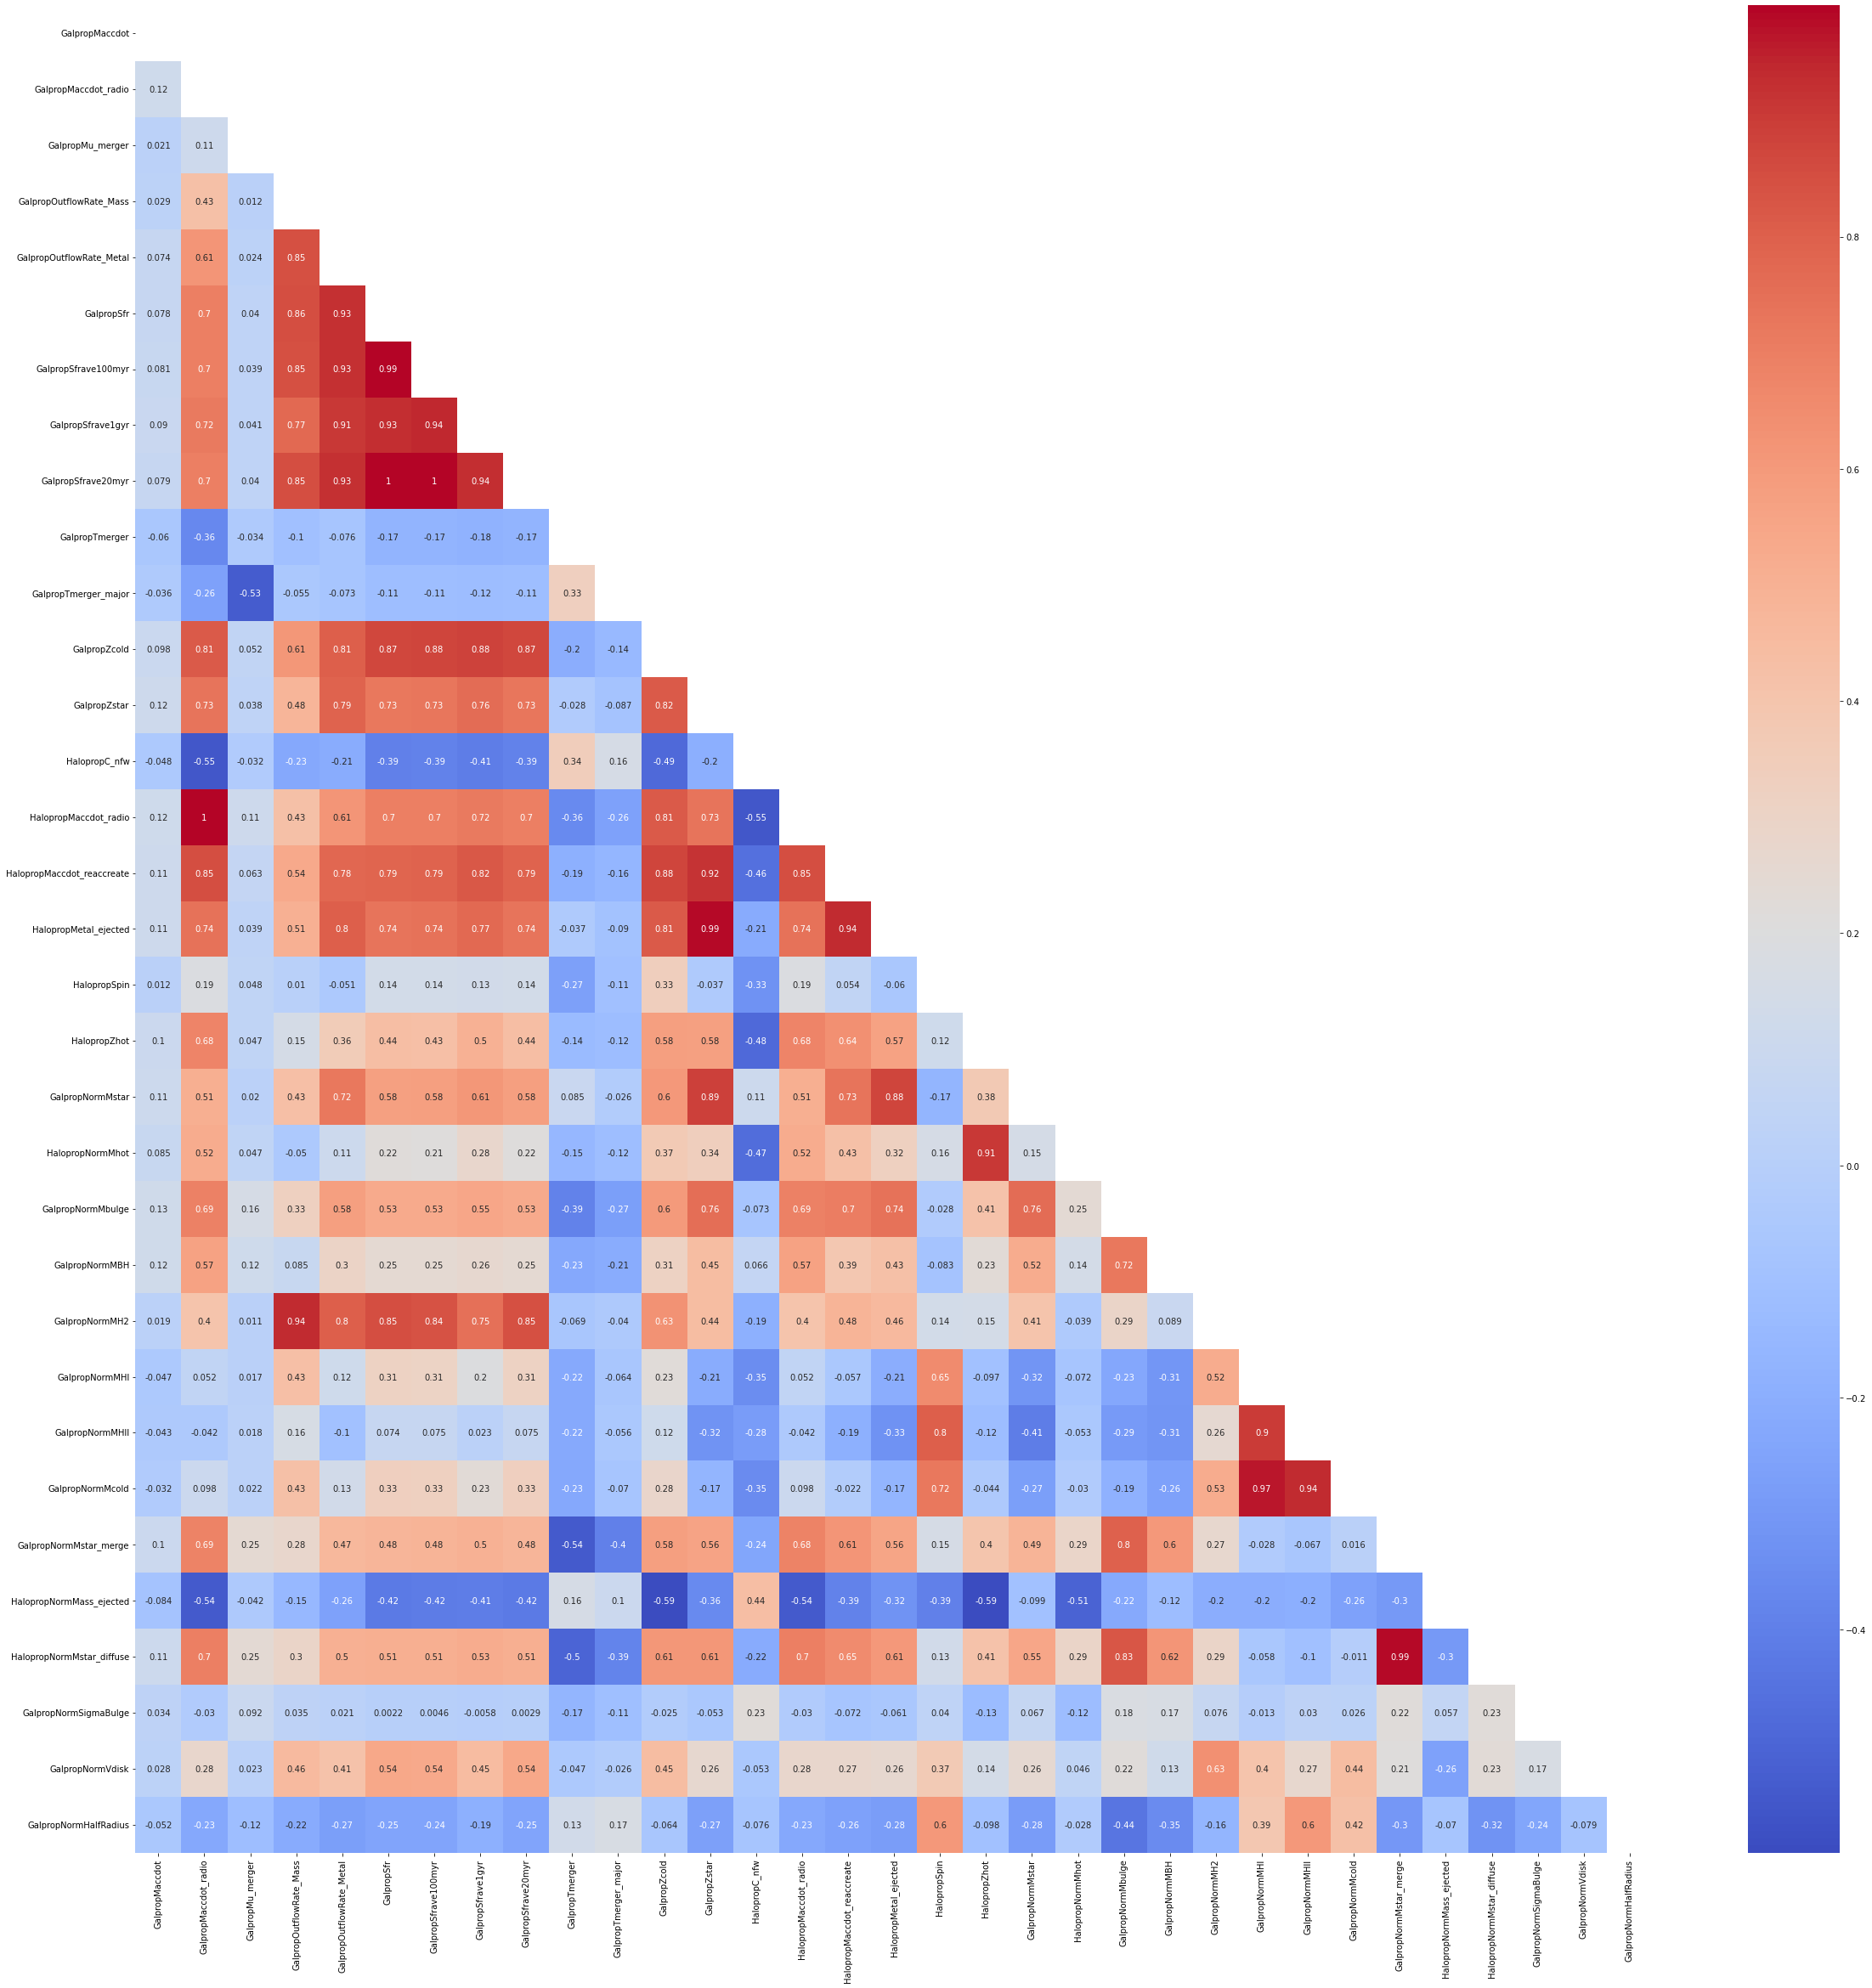

In [13]:
corr_df = df_pairplot.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm",annot=True, mask=matrix)
# plt.title("Spearman Correlation of TNG-SAM ", fontsize = 20)
# plt.xlabel("Features", fontsize = 20)
# plt.savefig('TNG-SAM_morefeatures_Spearman_Normalized_correlation_matrix.jpeg', dpi=500)
plt.show()

# ML modelling

## 4. 33-feature Dataset: Define labels and target (X,y)

In [37]:
X = df_normalized.drop(columns=['GalpropNormHalfRadius'])


y = df_normalized.loc[:,'GalpropNormHalfRadius']

### 5. Define the functions

In [45]:
def target_predicting_LR_function(X, y, params = {}):
    '''This function takes in a dataframe of X(features) and y (a target) and outputs predictions of the 
    target through Linear Regression model'''
    
        
    reg = LinearRegression() # choose the model: Linear Regression
    reg.fit(X, y) # fit the data to the chosen model
    # predict y (galaxy sizes) by using 5-fold cross-validation
    y_pred_LR = cross_val_predict(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))
    # find prediction scores of each of the cross validation fold
    scores_reg = cross_validate(reg, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10),
                               return_train_score=True)
    print("LR Accuracy: %0.2f (+/- %0.2f)" % (scores_reg['test_score'].mean(), scores_reg['test_score'].std() * 2))
    # Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(5, 5))
    label = 'Train score={} \n Test score={}'.format(round(scores_reg['train_score'].mean(), 2),round(scores_reg['test_score'].mean(), 2) )
    ax = plt.subplot()
    ax.scatter(y, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
    ax.set_xlim([0.0,100])
    ax.set_ylim([0.0,100])
    ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
    ax.set_title('Prediction vs True Value with LR, all features ')
    ax.set_xlabel('True Galaxy Size/Halo Size')
    ax.set_ylabel(' Predicted Galaxy Size/Halo Size')
    ax.legend(loc='lower right')

    fig_prediction.tight_layout()
#         plt.savefig('Linear Regression results.jpg', dpi=500)
    plt.show()
    
    return y_pred_LR, fig_prediction

In [51]:
def target_predicting_SVR_function(X, y, params = {}):
    '''This function takes in a dataframe of X(features) and y (a target) and outputs predictions of the 
    target through Support Vector Regressior model'''
    
        
    start_time = time.time()

    piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

    piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

    #optimizing SVR

    parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale'], 'svr__C':[1000], \
              }

    model = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

    model.fit(X, y)

    print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the GridSearchCV for SVR: {elapsed_time:.3f} seconds")
    
    best_SVR=model.best_estimator_
    best_SVR_trainscore=model.cv_results_['mean_train_score'][model.best_index_]
    scores_SVR = cross_val_score(best_SVR, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10)) 
    y_pred_SVR = cross_val_predict(best_SVR, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))
    
    print("SVR Accuracy: %0.2f (+/- %0.2f)" % (scores_SVR.mean(), scores_SVR.std() * 2))
    # Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(5, 5))
    label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore, 2),round(scores_SVR.mean(), 2) )    
    ax = plt.subplot()
    ax.scatter(y, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
    ax.set_xlim([0.0,100])
    ax.set_ylim([0.0,100])
    ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
    ax.set_title('Prediction vs True Value with SVR & 33 features ')
    ax.set_xlabel('True Galaxy Size/Halo Size')
    ax.set_ylabel(' Predicted Galaxy Size/Halo Size')
    ax.legend(loc='lower right')

    fig_prediction.tight_layout()
#         plt.savefig('Linear Regression results.jpg', dpi=500)
    plt.show()
    
    return y_pred_SVR, fig_prediction

In [32]:
def run_random_search_pipeline(X, y):
    
    
#     n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
#     grid = {'bootstrap': [True],
#                    'max_depth': [5, 10, None],
#     #                'max_features': ['auto', 'sqrt'],
#                    'min_samples_leaf': [1, 2, 4],
#     #                'min_samples_split': [2, 5, 10],
#                    'n_estimators': n_estimators}

    n_estimators = [20,50,100]
    grid = {'bootstrap': [True],
                   'max_depth': [5, 10, None],
    #                'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [2],
    #                'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    
#     pipeline = make_pipeline(RandomForestRegressor())
    model=RandomForestRegressor(random_state=0)

    reg_RF = GridSearchCV(model, grid, cv = KFold(n_splits=3, shuffle=True), \
                         verbose = 3, n_jobs = -1, return_train_score=True)
    reg_RF.fit(X, y)
#     estimator.get_params().keys()
    scores_lim = pd.DataFrame(reg_RF.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim['mean_test_score']

In [33]:

def calculate_r_score(X,y, column_names):
    x_new = X[list(column_names)]
    # print(column_names)
    r_square = run_random_search_pipeline(x_new, y)
    
    return r_square.max()

In [34]:
def print_results(max_col_names, max_col_rscores):
    k= 1
    for i, j in zip(max_col_names, max_col_rscores):
        print("\t", k, i,j)
        k +=1

In [35]:
def calc_ith_iteration(X, y, max_col_names, max_col_rscores, orj_column_names, i):
    r_score_dict = {}
    for column_names in tqdm(orj_column_names): # orj_column_names = original column names
        # count += 1
        # print(count, max_col_names , column_names)
        feature_list = max_col_names + [column_names]
        r_score = calculate_r_score(X, y, feature_list)
        r_score_dict[column_names] = r_score
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))
    # print("asdfasd", max_col_names[len(max_col_names) - 1])
    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    return max_col_names, max_col_rscores, orj_column_names, r_score_dict

In [52]:
def target_predicting_RF_function(X, y, params = {}):
    '''This function takes in a dataframe of X(features) and y (a target) and outputs predictions of the 
    target through the Random Forest Regressor ML model'''
    
        
    regr_RF = RandomForestRegressor(random_state=0)

    # number of trees in random forest
    n_estimators = [20,50,100]
    # create random grid
    grid = {'bootstrap': [True],
                   'max_depth': [5, 10, None],
    #                'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4],
    #                'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    # Grid search of parameters
    rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                         verbose = 1, n_jobs = -1, return_train_score=True)

    rfr_grid.fit(X, y)

    print('Best params, best score:', "{:.4f}".format(rfr_grid.best_score_), \
        rfr_grid.best_params_)
    # define trainscore according to best model
    best_RF=rfr_grid.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

    best_RF_trainscore=rfr_grid.cv_results_['mean_train_score'][rfr_grid.best_index_]

    # predict y (galaxy sizes) by using 5-fold cross-validation
    y_pred_RF = cross_val_predict(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

    # find prediction scores of each of the cross validation fold
    scores_RF = cross_val_score(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))
    print("RF Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))
    
    # Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(5, 5))

    label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
    ax = plt.subplot()
    ax.scatter(y, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
    ax.set_xlim([0.0,100])
    ax.set_ylim([0.0,100])
    ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
    ax.set_title('Prediction vs True Value with RF & all features ', fontsize=14)
    ax.set_xlabel('True Galaxy Size/Halo Size ', fontsize=12)
    ax.set_ylabel('Predicted Galaxy Size/Halo Size', fontsize=12)
    ax.legend(loc='lower right')

    fig_prediction.tight_layout()
    # plt.savefig('Prediction_vs_True.jpeg', dpi=500)

    plt.show()
        
    # Extract important features using built-in functions
    start_time = time.time()
    importances = rfr_grid.best_estimator_.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.estimators_], axis=0)
    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


    feature_names = X.columns

    forest_importances = pd.Series(importances, index=feature_names)

    fig_perm_import, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
    fig_perm_import.suptitle('TNG-SAM Feature Importances  ', fontsize=16, fontweight='bold')

    forest_importances.plot.bar(yerr=std, ax=ax1)
    ax1.set_title("Feature importances using Mean Decrease in Impurity")
    ax1.set_ylabel("Mean decrease in impurity")

    ### Feature Importances Permutation

    start_time = time.time()
    result = permutation_importance(
        rfr_grid.best_estimator_, X, y, n_repeats=10, random_state=0, n_jobs=-1
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    forest_importances = pd.Series(result.importances_mean, index=feature_names)

    forest_importances.plot.bar(yerr=result.importances_std, ax=ax2)
    ax2.set_title("Feature importances using Permutation Importances ")
    ax2.set_ylabel("Mean accuracy decrease")
    fig_perm_import.tight_layout()
    # plt.savefig("Feature_Importances_v2.jpeg", dpi=500)

    plt.show()

    df_perm_import=pd.DataFrame(forest_importances).sort_values(0, ascending=False)
    df_perm_import.to_csv('RF built in Feature Importances Permutation.csv', index=False)

    # Add-feature Ranking Method
    # Note: This step calls 4 funcitons: run_random_search_pipeline(X,y), calculate_r_score(column_names),
    # print_results(max_col_names, max_col_rscores), calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i)

    column_names = X.columns
        
    # init
    
    max_col_names = [] # 
    max_col_rscores = []
    orj_column_names = list(X.columns)

    # main 
    for i in range(1, len(orj_column_names)+1):
        max_col_names, max_col_rscores, orj_column_names, r_score_dict = \
            calc_ith_iteration(X, y, max_col_names, max_col_rscores, orj_column_names, i)

        print(f"{i}. iteration: ")
        print_results(max_col_names, max_col_rscores)
        if i==17: break

    df_max_r_scores = pd.DataFrame({
    'feature_number' : range(1,18),
    'features':max_col_names,
    'r_sq_score': max_col_rscores  })
    # Save the important feature ranking obtained by add-column method
    #df_max_r_scores.to_csv('Max r scores by add column method.csv', index=False)

    fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                        legend=False, grid=True, 
                        xticks=range(0,18))
    fig_add_feature.set_title(label= 'R square score by add-feature method',fontsize=16)
    fig_add_feature.set_xlabel('Features',fontsize=16)
    fig_add_feature.set_ylabel('R score',fontsize=16)
    
#     fig_add_feature.get_figure().savefig('R score by add-feature method.jpg', dpi=500)

    plt.show()
    
    return y_pred_RF, fig_prediction, fig_perm_import, df_perm_import, df_max_r_scores, fig_add_feature



      

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9175 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
RF Accuracy: 0.92 (+/- 0.01)


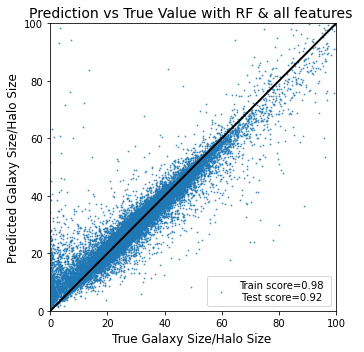

Elapsed time to compute the importances: 0.022 seconds
Elapsed time to compute the importances: 63.086 seconds


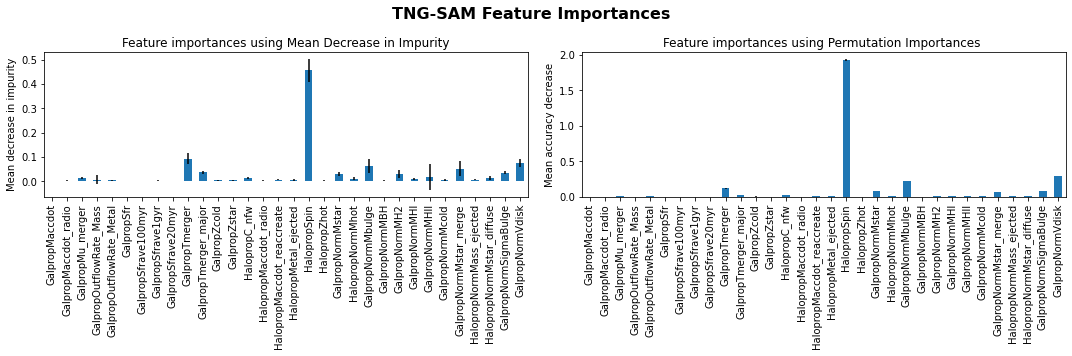

  0%|                                                    | 0/32 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/32 [00:00<00:22,  1.38it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/32 [00:02<00:48,  1.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████▏                                       | 3/32 [00:10<02:00,  4.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 4/32 [00:16<02:22,  5.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|██████▉                                     | 5/32 [00:23<02:33,  5.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▎                                   | 6/32 [00:30<02:36,  6.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▋                                  | 7/32 [00:36<02:32,  6.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 8/32 [00:42<02:28,  6.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▍                               | 9/32 [00:48<02:22,  6.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▍                             | 10/32 [00:54<02:12,  6.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 11/32 [00:58<01:53,  5.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▏                          | 12/32 [01:05<01:54,  5.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▍                         | 13/32 [01:12<01:59,  6.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▊                        | 14/32 [01:20<02:03,  6.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▏                      | 15/32 [01:22<01:31,  5.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 16/32 [01:30<01:36,  6.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▊                    | 17/32 [01:37<01:37,  6.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████▏                  | 18/32 [01:43<01:25,  6.13s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▌                 | 19/32 [01:50<01:23,  6.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 20/32 [01:56<01:17,  6.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|████████████████████████████▏              | 21/32 [02:01<01:06,  6.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▌             | 22/32 [02:08<01:00,  6.09s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 23/32 [02:09<00:43,  4.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 24/32 [02:15<00:40,  5.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▌         | 25/32 [02:22<00:38,  5.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▉        | 26/32 [02:28<00:34,  5.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████▎      | 27/32 [02:35<00:29,  5.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 28/32 [02:39<00:22,  5.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|██████████████████████████████████████▉    | 29/32 [02:46<00:18,  6.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▎  | 30/32 [02:50<00:10,  5.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▋ | 31/32 [02:57<00:05,  5.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 32/32 [03:01<00:00,  5.67s/it]


1. iteration: 
	 1 HalopropSpin 0.38446914395172643


  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/31 [00:05<02:43,  5.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 2/31 [00:15<04:01,  8.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▎                                       | 3/31 [00:26<04:22,  9.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 4/31 [00:38<04:39, 10.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 5/31 [00:47<04:18,  9.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▌                                   | 6/31 [00:57<04:06,  9.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|█████████▉                                  | 7/31 [01:06<03:51,  9.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▎                                | 8/31 [01:15<03:39,  9.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 9/31 [01:25<03:32,  9.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▊                             | 10/31 [01:34<03:17,  9.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.004, test=-0.001) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.003, test=0.002) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.005, test=0.002) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.007, test=-0.000) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.028, test=0.018) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.039, test=0.020) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.038, test=0.023) total time=   0.3s
[CV 3/3] END bo

 35%|██████████████▏                         | 11/31 [11:18<1:01:44, 185.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▎                         | 12/31 [11:27<41:43, 131.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████                         | 13/31 [11:38<28:28, 94.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▍                       | 14/31 [11:48<19:38, 69.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 15/31 [11:58<13:43, 51.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 16/31 [12:09<09:48, 39.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▌                   | 17/31 [12:20<07:11, 30.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▉                  | 18/31 [12:32<05:27, 25.18s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 19/31 [12:41<04:05, 20.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▋               | 20/31 [12:53<03:15, 17.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 21/31 [13:03<02:36, 15.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.004, test=0.001) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.006, test=0.000) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.006, test=-0.001) total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.006, test=0.002) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.029, test=0.018) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.063, test=-0.007) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.030, test=0.017) total time=   0.5s
[CV 1/3] E

 71%|██████████████████████████████▌            | 22/31 [13:15<02:08, 14.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.006, test=0.000) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.005, test=0.002) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.006, test=-0.003) total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.024, test=0.025) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.028, test=0.018) total time=   0.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.058, test=0.006) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.030, test=0.014) total time=   1.0s
[CV 3/3] END 

 74%|███████████████████████████████▉           | 23/31 [13:26<01:47, 13.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▎         | 24/31 [13:38<01:30, 12.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 25/31 [13:49<01:14, 12.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.003, test=0.002) total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.004, test=-0.001) total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.005, test=0.002) total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.029, test=0.018) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.038, test=0.022) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.059, test=-0.002) total time=   0.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.029, test=0.016) total time=   0.2s
[CV 2/3] END

 84%|████████████████████████████████████       | 26/31 [14:01<01:01, 12.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 87%|█████████████████████████████████████▍     | 27/31 [14:11<00:46, 11.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▊    | 28/31 [14:20<00:32, 10.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▏  | 29/31 [14:30<00:21, 10.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 30/31 [14:40<00:10, 10.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 31/31 [14:49<00:00, 28.70s/it]


2. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  3%|█▍                                          | 1/30 [00:09<04:24,  9.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|██▉                                         | 2/30 [00:24<05:55, 12.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 3/30 [00:39<06:18, 14.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▊                                      | 4/30 [00:55<06:21, 14.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 5/30 [01:11<06:16, 15.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 6/30 [01:26<06:06, 15.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▎                                 | 7/30 [01:42<05:54, 15.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▋                                | 8/30 [01:58<05:43, 15.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 9/30 [02:14<05:28, 15.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▎                            | 10/30 [02:27<04:59, 14.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 37%|███████████████▊                           | 11/30 [02:41<04:37, 14.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 12/30 [02:57<04:30, 15.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 13/30 [03:13<04:20, 15.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████                       | 14/30 [03:29<04:07, 15.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 15/30 [03:42<03:42, 14.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▉                    | 16/30 [04:00<03:41, 15.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 17/30 [04:17<03:28, 16.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 18/30 [04:34<03:14, 16.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 19/30 [04:51<03:02, 16.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 20/30 [05:07<02:43, 16.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 21/30 [05:25<02:31, 16.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▌           | 22/30 [05:40<02:11, 16.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|████████████████████████████████▉          | 23/30 [05:56<01:54, 16.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 24/30 [06:13<01:38, 16.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 25/30 [06:30<01:22, 16.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.627, test=0.485) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.820, test=0.430) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.833, test=0.429) total time=   4.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.492, test=0.439) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.812, test=0.396) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.825, test=0.393) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.525, test=0.505) total time=   0.9s
[CV 3/3]

 87%|█████████████████████████████████████▎     | 26/30 [06:46<01:05, 16.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.823, test=0.411) total time=   4.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.532, test=0.504) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.635, test=0.477) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.833, test=0.445) total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.526, test=0.497) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.634, test=0.486) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.825, test=0.442) total time=   1.0s
[CV 2/3] EN

 90%|██████████████████████████████████████▋    | 27/30 [06:59<00:46, 15.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████▏  | 28/30 [07:15<00:31, 15.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 29/30 [07:31<00:15, 15.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 30/30 [07:46<00:00, 15.55s/it]


3. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.818, test=0.414) total time=   4.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.524, test=0.516) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.635, test=0.486) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.834, test=0.438) total time=   2.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.571, test=0.560) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.663, test=0.539) total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.849, test=0.489) total time=   2.3s
[CV 1/3] EN

  3%|█▌                                          | 1/29 [00:16<07:32, 16.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███                                         | 2/29 [00:36<08:22, 18.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▌                                       | 3/29 [00:57<08:29, 19.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 4/29 [01:17<08:20, 20.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▌                                    | 5/29 [01:35<07:41, 19.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████                                   | 6/29 [01:59<07:55, 20.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 7/29 [02:20<07:41, 20.99s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 8/29 [02:44<07:40, 21.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▋                              | 9/29 [03:07<07:26, 22.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 34%|██████████████▊                            | 10/29 [03:25<06:35, 20.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▎                          | 11/29 [03:44<06:05, 20.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▊                         | 12/29 [04:05<05:49, 20.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▎                       | 13/29 [04:27<05:33, 20.86s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▊                      | 14/29 [04:48<05:15, 21.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▏                    | 15/29 [05:10<04:56, 21.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 16/29 [05:34<04:47, 22.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▏                 | 17/29 [05:56<04:23, 21.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▋                | 18/29 [06:20<04:08, 22.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 66%|████████████████████████████▏              | 19/29 [06:40<03:40, 22.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▋             | 20/29 [07:04<03:22, 22.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████▏           | 21/29 [07:24<02:55, 21.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▌          | 22/29 [07:48<02:36, 22.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 23/29 [08:12<02:16, 22.75s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▌       | 24/29 [08:35<01:54, 22.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████      | 25/29 [09:01<01:35, 23.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▌    | 26/29 [09:24<01:10, 23.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|████████████████████████████████████████   | 27/29 [09:46<00:46, 23.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 97%|█████████████████████████████████████████▌ | 28/29 [10:04<00:21, 21.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 29/29 [10:30<00:00, 21.75s/it]


4. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▌                                          | 1/28 [00:23<10:26, 23.19s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.892, test=0.585) total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.893, test=0.614) total time=   3.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.640, test=0.618) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.896, test=0.627) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.903, test=0.643) total time=   3.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.639, test=0.615) total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.752, test=0.644) total time=   2.0s
[CV 3/3] 

  7%|███▏                                        | 2/28 [00:52<11:31, 26.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▋                                       | 3/28 [01:17<10:45, 25.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.640, test=0.617) total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.896, test=0.615) total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.901, test=0.623) total time=   3.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.619, test=0.604) total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.882, test=0.578) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.888, test=0.597) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.622, test=0.600) total time=   2.5s
[CV 3/3]

 14%|██████▎                                     | 4/28 [01:47<11:08, 27.83s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 5/28 [02:17<10:51, 28.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 21%|█████████▍                                  | 6/28 [02:44<10:13, 27.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 7/28 [03:13<09:56, 28.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.907, test=0.637) total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.627, test=0.612) total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.766, test=0.668) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.767, test=0.678) total time=   4.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.909, test=0.659) total time=   5.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.600, test=0.565) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.713, test=0.584) total time=   2.1s
[CV 1/3] EN

 29%|████████████▌                               | 8/28 [03:38<09:02, 27.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████▏                             | 9/28 [04:05<08:36, 27.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▎                           | 10/28 [04:31<08:04, 26.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|████████████████▉                          | 11/28 [04:56<07:29, 26.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▍                        | 12/28 [05:24<07:06, 26.64s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▉                       | 13/28 [05:51<06:42, 26.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 14/28 [06:18<06:15, 26.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████                    | 15/28 [06:44<05:45, 26.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 16/28 [07:11<05:20, 26.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████                 | 17/28 [07:38<04:55, 26.87s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▋               | 18/28 [08:05<04:29, 27.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 19/28 [08:33<04:03, 27.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 20/28 [08:59<03:34, 26.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 21/28 [09:25<03:06, 26.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▊         | 22/28 [09:52<02:40, 26.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▎       | 23/28 [10:19<02:13, 26.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 24/28 [10:46<01:47, 26.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▍    | 25/28 [11:13<01:20, 26.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▉   | 26/28 [11:40<00:53, 26.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 27/28 [12:10<00:27, 27.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 28/28 [12:37<00:00, 27.05s/it]


5. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/27 [00:26<11:31, 26.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  7%|███▎                                        | 2/27 [00:51<10:42, 25.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 3/27 [01:22<11:14, 28.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 4/27 [01:54<11:23, 29.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▏                                   | 5/27 [02:26<11:06, 30.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 6/27 [02:57<10:40, 30.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 7/27 [03:27<10:12, 30.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████                               | 8/27 [03:58<09:41, 30.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 9/27 [04:28<09:09, 30.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.928, test=0.728) total time=   7.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.655, test=0.632) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.809, test=0.722) total time=   3.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.930, test=0.721) total time=   4.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.654, test=0.627) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.796, test=0.716) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.916, test=0.691) total time=   1.6s
[CV 2/3] EN

 37%|███████████████▉                           | 10/27 [04:59<08:40, 30.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|█████████████████▌                         | 11/27 [05:29<08:04, 30.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████                        | 12/27 [05:59<07:35, 30.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.647, test=0.624) total time=   3.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.917, test=0.694) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.923, test=0.697) total time=   7.7s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.659, test=0.631) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.803, test=0.733) total time=   1.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.810, test=0.730) total time=   7.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.649, test=0.608) total time=   0.7s
[CV 2/3] END

 48%|████████████████████▋                      | 13/27 [06:30<07:05, 30.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.935, test=0.735) total time=   7.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.662, test=0.630) total time=   0.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.676, test=0.635) total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.942, test=0.776) total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.787) total time=   7.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.647, test=0.605) total time=   0.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.795, test=0.692) total time=   1.1s
[CV 1/3] E

 52%|██████████████████████▎                    | 14/27 [07:00<06:34, 30.38s/it]

score=(train=0.952, test=0.829) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.957, test=0.827) total time=   8.3s
Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▉                   | 15/27 [07:30<06:02, 30.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 16/27 [08:01<05:33, 30.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████                | 17/27 [08:31<05:04, 30.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 18/27 [09:02<04:33, 30.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████▎            | 19/27 [09:32<04:03, 30.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 74%|███████████████████████████████▊           | 20/27 [10:05<03:38, 31.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 21/27 [10:36<03:06, 31.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|███████████████████████████████████        | 22/27 [11:11<02:41, 32.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▋      | 23/27 [11:44<02:09, 32.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 24/27 [12:16<01:37, 32.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 93%|███████████████████████████████████████▊   | 25/27 [12:52<01:06, 33.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▍ | 26/27 [13:25<00:33, 33.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 27/27 [13:58<00:00, 31.04s/it]


6. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▋                                          | 1/26 [00:35<14:50, 35.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▍                                        | 2/26 [01:12<14:33, 36.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████                                       | 3/26 [01:51<14:23, 37.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▊                                     | 4/26 [02:27<13:31, 36.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 5/26 [03:02<12:43, 36.38s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████▏                                 | 6/26 [03:39<12:11, 36.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|███████████▊                                | 7/26 [04:16<11:35, 36.62s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▌                              | 8/26 [04:51<10:52, 36.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▏                            | 9/26 [05:27<10:12, 36.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                          | 10/26 [05:56<08:59, 33.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▏                        | 11/26 [06:32<08:36, 34.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▊                       | 12/26 [07:07<08:07, 34.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 13/26 [07:44<07:38, 35.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▏                   | 14/26 [08:19<07:04, 35.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|████████████████████████▊                  | 15/26 [08:54<06:27, 35.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▍                | 16/26 [09:30<05:53, 35.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|████████████████████████████               | 17/26 [10:06<05:19, 35.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▊             | 18/26 [10:42<04:46, 35.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▍           | 19/26 [11:17<04:09, 35.67s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.904) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.980, test=0.927) total time=   7.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.712, test=0.682) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.882, test=0.817) total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.891, test=0.813) total time=   6.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.715, test=0.678) total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.889, test=0.822) total time=   1.3s
[CV 3/3] END

 77%|█████████████████████████████████          | 20/26 [11:52<03:32, 35.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▋        | 21/26 [12:31<03:02, 36.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.896, test=0.816) total time=   6.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.714, test=0.688) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.894, test=0.821) total time=   3.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.952, test=0.817) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.955, test=0.836) total time=   8.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.713, test=0.681) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.890, test=0.830) total time=   3.3s
[CV 1/3] END

 85%|████████████████████████████████████▍      | 22/26 [13:10<02:29, 37.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.714, test=0.681) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.885, test=0.821) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.895, test=0.808) total time=   6.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.957, test=0.829) total time=   7.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.721, test=0.685) total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.883, test=0.805) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.885, test=0.810) total time=   6.6s
[CV 3/3] END 

 88%|██████████████████████████████████████     | 23/26 [13:50<01:54, 38.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▋   | 24/26 [14:29<01:16, 38.36s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 25/26 [15:09<00:38, 38.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 26/26 [15:40<00:00, 36.19s/it]


7. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/25 [00:39<15:55, 39.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.489, test=0.443) total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.816, test=0.373) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.823, test=0.407) total time=   4.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.485, test=0.442) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.563, test=0.461) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.813, test=0.384) total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.440, test=0.391) total time=   0.3s
[CV 1/3] EN

  8%|███▌                                        | 2/25 [01:26<16:51, 43.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.483, test=0.456) total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.580, test=0.462) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.824, test=0.398) total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.484, test=0.442) total time=   0.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.572, test=0.421) total time=   0.6s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.578, test=0.427) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.814, test=0.349) total time=   1.2s
[CV 2/3] END

 12%|█████▎                                      | 3/25 [02:11<16:17, 44.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 16%|███████                                     | 4/25 [02:56<15:32, 44.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.475, test=0.469) total time=   0.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.594, test=0.442) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.818, test=0.408) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.480, test=0.445) total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.577, test=0.426) total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.434, test=0.401) total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.533, test=0.399) total time=   1.4s
[CV 3/3] END bo

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.489, test=0.445) total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.584, test=0.454) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.825, test=0.385) total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.468, test=0.468) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.575, test=0.434) total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.574, test=0.433) total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.422, test=0.409) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=1

 20%|████████▊                                   | 5/25 [03:40<14:49, 44.46s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▌                                 | 6/25 [04:25<14:05, 44.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.475, test=0.468) total time=   1.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.812, test=0.394) total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.822, test=0.392) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.479, test=0.446) total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.574, test=0.429) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.814, test=0.365) total time=   3.0s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.433, test=0.401) total time=   1.7s
[CV 1/3] EN

[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.726, test=0.707) total time=   4.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.977, test=0.918) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.981, test=0.916) total time=   5.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.734, test=0.705) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.940, test=0.889) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.944, test=0.892) total time=   8.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.724, test=0.701) total time=   2.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimato

 28%|████████████▎                               | 7/25 [05:09<13:19, 44.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 8/25 [05:50<12:14, 43.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|███████████████▊                            | 9/25 [06:30<11:16, 42.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▏                         | 10/25 [07:10<10:24, 41.63s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|██████████████████▉                        | 11/25 [07:49<09:32, 40.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▋                      | 12/25 [08:32<09:00, 41.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▎                    | 13/25 [09:16<08:25, 42.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████                   | 14/25 [10:01<07:52, 42.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 15/25 [10:46<07:16, 43.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▌               | 16/25 [11:29<06:31, 43.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▏             | 17/25 [12:11<05:45, 43.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|██████████████████████████████▉            | 18/25 [12:55<05:02, 43.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▋          | 19/25 [13:38<04:19, 43.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 20/25 [14:23<03:38, 43.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 84%|████████████████████████████████████       | 21/25 [15:08<02:56, 44.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▊     | 22/25 [15:51<02:11, 43.85s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▌   | 23/25 [16:35<01:27, 43.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▎ | 24/25 [17:11<00:41, 41.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 25/25 [17:54<00:00, 42.99s/it]


8. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▊                                          | 1/24 [00:45<17:19, 45.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  8%|███▋                                        | 2/24 [01:34<17:28, 47.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 3/24 [02:23<16:53, 48.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 4/24 [03:11<16:00, 48.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.985, test=0.932) total time=   6.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.740, test=0.705) total time=   5.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.934) total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.986, test=0.932) total time=   6.5s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.738, test=0.702) total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.949, test=0.891) total time=   2.2s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.906) total time=  11.1s
[CV 1/3] E

 21%|█████████▏                                  | 5/24 [03:52<14:26, 45.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.721, test=0.697) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.949, test=0.897) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.905) total time=   9.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.926) total time=   9.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.742, test=0.705) total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.744, test=0.708) total time=   5.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.941) total time=   2.5s
[CV 1/3] END

 25%|███████████                                 | 6/24 [04:42<14:10, 47.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▊                               | 7/24 [05:29<13:17, 46.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.909) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.901) total time=   4.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.941) total time=   6.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.733, test=0.719) total time=   3.1s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.912) total time=   5.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.984, test=0.921) total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.938) total time=  10.7s
[CV 2/3] E

 33%|██████████████▋                             | 8/24 [06:07<11:44, 44.04s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 9/24 [06:53<11:10, 44.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|█████████████████▉                         | 10/24 [10:24<22:24, 96.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 46%|███████████████████▋                       | 11/24 [11:09<17:27, 80.54s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 12/24 [11:57<14:06, 70.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 54%|███████████████████████▎                   | 13/24 [12:42<11:30, 62.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 58%|█████████████████████████                  | 14/24 [13:33<09:52, 59.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 15/24 [14:20<08:20, 55.57s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 16/24 [15:07<07:04, 53.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▍            | 17/24 [15:54<05:59, 51.30s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 18/24 [16:42<05:00, 50.12s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|██████████████████████████████████         | 19/24 [17:29<04:06, 49.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 20/24 [18:09<03:05, 46.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 21/24 [18:59<02:22, 47.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 92%|███████████████████████████████████████▍   | 22/24 [19:48<01:36, 48.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 23/24 [20:36<00:47, 47.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 24/24 [21:17<00:00, 53.22s/it]


9. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905
	 9 HalopropC_nfw 0.9346272984640849


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  4%|█▉                                          | 1/23 [00:49<18:03, 49.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|███▊                                        | 2/23 [01:47<18:59, 54.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 13%|█████▋                                      | 3/23 [02:32<16:41, 50.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▋                                    | 4/23 [03:25<16:14, 51.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▌                                  | 5/23 [04:21<15:57, 53.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▍                                | 6/23 [05:16<15:14, 53.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▍                              | 7/23 [06:10<14:20, 53.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▎                            | 8/23 [07:07<13:40, 54.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████▏                          | 9/23 [08:01<12:43, 54.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 43%|██████████████████▋                        | 10/23 [08:57<11:53, 54.90s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▌                      | 11/23 [09:51<10:55, 54.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 52%|██████████████████████▍                    | 12/23 [10:44<09:57, 54.35s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▎                  | 13/23 [11:36<08:54, 53.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▏                | 14/23 [12:27<07:54, 52.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|████████████████████████████               | 15/23 [13:23<07:09, 53.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|█████████████████████████████▉             | 16/23 [14:09<05:59, 51.34s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.743, test=0.713) total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.890) total time=   2.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.907) total time=  12.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.744, test=0.712) total time=   7.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.927) total time=   3.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.985, test=0.920) total time=   9.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.732, test=0.715) total time=   3.8s
[CV 1/3] END 

 74%|███████████████████████████████▊           | 17/23 [15:06<05:18, 53.10s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▋         | 18/23 [16:02<04:30, 54.06s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.940) total time=   8.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.740, test=0.710) total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.916) total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.956, test=0.908) total time=  13.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.922) total time=  12.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.737, test=0.723) total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.953, test=0.904) total time=   2.3s
[CV 2/3] END

 83%|███████████████████████████████████▌       | 19/23 [16:58<03:38, 54.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.936) total time=   6.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.734, test=0.704) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.955, test=0.896) total time=  10.8s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.733, test=0.703) total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.948, test=0.899) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.956, test=0.913) total time=  12.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.732, test=0.692) total time=   1.3s
[CV 3/3] END b

 87%|█████████████████████████████████████▍     | 20/23 [17:52<02:43, 54.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████▎   | 21/23 [18:46<01:48, 54.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 96%|█████████████████████████████████████████▏ | 22/23 [19:39<00:53, 53.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 23/23 [20:34<00:00, 53.69s/it]


10. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905
	 9 HalopropC_nfw 0.9346272984640849
	 10 GalpropNormMcold 0.9330932489527873


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/22 [00:44<15:44, 45.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  9%|████                                        | 2/22 [01:42<17:22, 52.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████                                      | 3/22 [02:44<18:02, 56.95s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|████████                                    | 4/22 [03:50<18:03, 60.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 23%|██████████                                  | 5/22 [04:52<17:15, 60.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 27%|████████████                                | 6/22 [05:50<15:58, 59.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|██████████████                              | 7/22 [06:47<14:45, 59.03s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 36%|████████████████                            | 8/22 [07:44<13:37, 58.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 9/22 [08:40<12:31, 57.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▌                       | 10/22 [09:37<11:28, 57.39s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 11/22 [10:32<10:24, 56.79s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▍                   | 12/22 [11:29<09:26, 56.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▍                 | 13/22 [12:25<08:28, 56.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 64%|███████████████████████████▎               | 14/22 [13:20<07:29, 56.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▎             | 15/22 [14:17<06:33, 56.28s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 73%|███████████████████████████████▎           | 16/22 [15:13<05:37, 56.21s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 77%|█████████████████████████████████▏         | 17/22 [16:09<04:40, 56.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▏       | 18/22 [17:04<03:43, 55.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|█████████████████████████████████████▏     | 19/22 [18:01<02:48, 56.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 91%|███████████████████████████████████████    | 20/22 [18:47<01:46, 53.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|█████████████████████████████████████████  | 21/22 [19:43<00:53, 54.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 22/22 [20:39<00:00, 56.35s/it]


11. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905
	 9 HalopropC_nfw 0.9346272984640849
	 10 GalpropNormMcold 0.9330932489527873
	 11 GalpropSfrave100myr 0.9331076621693214


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██                                          | 1/21 [00:46<15:24, 46.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▏                                       | 2/21 [01:47<17:23, 54.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 14%|██████▎                                     | 3/21 [02:48<17:20, 57.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▍                                   | 4/21 [03:50<16:47, 59.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 24%|██████████▍                                 | 5/21 [04:50<15:58, 59.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▌                               | 6/21 [05:41<14:08, 56.58s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 7/21 [06:42<13:35, 58.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.930) total time=  14.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.740, test=0.714) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.947, test=0.902) total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.954, test=0.915) total time=   6.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.986, test=0.923) total time=   9.1s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.739, test=0.719) total time=   7.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.934) total time=   3.6s
[CV 3/3] E

 38%|████████████████▊                           | 8/21 [07:43<12:49, 59.16s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.932) total time=  10.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.741, test=0.703) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.911) total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.958, test=0.896) total time=   7.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.935) total time=  10.5s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.737, test=0.696) total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.954, test=0.882) total time=   7.4s
[CV 3/3] END b

 43%|██████████████████▊                         | 9/21 [08:45<11:57, 59.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 48%|████████████████████▍                      | 10/21 [09:45<10:58, 59.89s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.955, test=0.901) total time=  13.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.739, test=0.715) total time=   3.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.901) total time=   6.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.935) total time=   8.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.732, test=0.711) total time=   2.1s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.953, test=0.895) total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.909) total time=   9.0s
[CV 2/3] END bo

 52%|██████████████████████▌                    | 11/21 [10:45<10:01, 60.15s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 57%|████████████████████████▌                  | 12/21 [11:36<08:34, 57.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▌                | 13/21 [12:37<07:46, 58.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 14/21 [13:38<06:54, 59.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▋            | 15/21 [14:28<05:39, 56.51s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▊          | 16/21 [15:30<04:50, 58.02s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▊        | 17/21 [16:30<03:55, 58.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 86%|████████████████████████████████████▊      | 18/21 [17:32<02:58, 59.55s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▉    | 19/21 [18:33<02:00, 60.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▉  | 20/21 [19:33<01:00, 60.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 21/21 [20:35<00:00, 58.83s/it]


12. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905
	 9 HalopropC_nfw 0.9346272984640849
	 10 GalpropNormMcold 0.9330932489527873
	 11 GalpropSfrave100myr 0.9331076621693214
	 12 GalpropSfrave20myr 0.9342233729951874


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▏                                         | 1/20 [01:01<19:24, 61.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 10%|████▍                                       | 2/20 [02:06<19:04, 63.61s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 15%|██████▌                                     | 3/20 [03:12<18:21, 64.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 20%|████████▊                                   | 4/20 [04:18<17:24, 65.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 5/20 [05:24<16:22, 65.49s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 30%|█████████████▏                              | 6/20 [06:30<15:17, 65.50s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 35%|███████████████▍                            | 7/20 [07:24<13:23, 61.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|█████████████████▌                          | 8/20 [08:30<12:39, 63.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 45%|███████████████████▊                        | 9/20 [09:35<11:42, 63.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████████████████████▌                     | 10/20 [10:41<10:44, 64.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 55%|███████████████████████▋                   | 11/20 [11:47<09:43, 64.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|█████████████████████████▊                 | 12/20 [12:52<08:39, 64.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▉               | 13/20 [13:58<07:37, 65.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|██████████████████████████████             | 14/20 [15:04<06:33, 65.53s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 15/20 [16:10<05:28, 65.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 80%|██████████████████████████████████▍        | 16/20 [17:16<04:22, 65.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 85%|████████████████████████████████████▌      | 17/20 [18:22<03:17, 65.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|██████████████████████████████████████▋    | 18/20 [19:27<02:11, 65.70s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▊  | 19/20 [20:33<01:05, 65.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 20/20 [21:39<00:00, 64.97s/it]


13. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905
	 9 HalopropC_nfw 0.9346272984640849
	 10 GalpropNormMcold 0.9330932489527873
	 11 GalpropSfrave100myr 0.9331076621693214
	 12 GalpropSfrave20myr 0.9342233729951874
	 13 GalpropZcold 0.9322138862646246


  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  5%|██▎                                         | 1/19 [01:05<19:47, 65.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▋                                       | 2/19 [02:15<19:21, 68.29s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.730, test=0.687) total time=   4.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.955, test=0.910) total time=   7.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.926) total time=  10.3s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.734, test=0.701) total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.951, test=0.916) total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.955, test=0.899) total time=  15.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.926) total time=  15.1s
[CV 2/3] END

 16%|██████▉                                     | 3/19 [03:26<18:30, 69.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.939) total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.925) total time=  17.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.731, test=0.699) total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.737, test=0.705) total time=   8.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.927) total time=   4.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.936) total time=  16.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.738, test=0.721) total time=   1.7s
[CV 1/3]

 21%|█████████▎                                  | 4/19 [04:37<17:29, 69.94s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 26%|███████████▌                                | 5/19 [05:48<16:23, 70.22s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 32%|█████████████▉                              | 6/19 [06:58<15:14, 70.33s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.927) total time=  10.4s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.737, test=0.706) total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.734, test=0.729) total time=   8.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.985, test=0.922) total time=   4.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.934) total time=  17.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.739, test=0.713) total time=   8.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.928) total time=   4.0s
[CV 3/3]

 37%|████████████████▏                           | 7/19 [08:09<14:05, 70.42s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 42%|██████████████████▌                         | 8/19 [09:20<12:56, 70.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▊                       | 9/19 [10:18<11:05, 66.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|██████████████████████▋                    | 10/19 [11:29<10:11, 67.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.890) total time=   9.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.980, test=0.924) total time=   9.6s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.745, test=0.728) total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.945, test=0.894) total time=   4.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.979, test=0.926) total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.929) total time=  11.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.735, test=0.719) total time=   5.3s
[CV 1/3]

 58%|████████████████████████▉                  | 11/19 [12:39<09:09, 68.69s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 63%|███████████████████████████▏               | 12/19 [13:49<08:04, 69.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 68%|█████████████████████████████▍             | 13/19 [15:00<06:58, 69.68s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.740, test=0.723) total time=   1.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.739, test=0.722) total time=   5.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.926) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.928) total time=  11.8s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.746, test=0.699) total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.897) total time=   4.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.984, test=0.923) total time=   2.5s
[CV 2/3] EN

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.728, test=0.717) total time=   5.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.937) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.923) total time=  10.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.735, test=0.691) total time=   5.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.915) total time=   9.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.730, test=0.710) total time=   5.3s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.896) total time=   9.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estim

 74%|███████████████████████████████▋           | 14/19 [16:11<05:50, 70.01s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 79%|█████████████████████████████████▉         | 15/19 [17:21<04:40, 70.07s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.952, test=0.906) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.954, test=0.895) total time=   4.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.932) total time=   6.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.727, test=0.716) total time=   2.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.909) total time=   4.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.981, test=0.926) total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.930) total time=  10.4s
[CV 1/3] E

[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.894) total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.953, test=0.884) total time=  16.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.982, test=0.937) total time=  15.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.735, test=0.712) total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.742, test=0.726) total time=   8.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.984, test=0.919) total time=   4.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.983, test=0.928) total time=  17.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_esti

 84%|████████████████████████████████████▏      | 16/19 [18:32<03:30, 70.31s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.951, test=0.893) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.948, test=0.907) total time=   9.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.934) total time=   9.8s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.735, test=0.701) total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.902) total time=   4.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.979, test=0.933) total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.935) total time=  10.6s
[CV 1/3]

 89%|██████████████████████████████████████▍    | 17/19 [19:43<02:20, 70.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 95%|████████████████████████████████████████▋  | 18/19 [20:53<01:10, 70.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 19/19 [21:51<00:00, 69.05s/it]


14. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905
	 9 HalopropC_nfw 0.9346272984640849
	 10 GalpropNormMcold 0.9330932489527873
	 11 GalpropSfrave100myr 0.9331076621693214
	 12 GalpropSfrave20myr 0.9342233729951874
	 13 GalpropZcold 0.9322138862646246
	 14 GalpropSfr 0.931665459491893


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▍                                         | 1/18 [00:58<16:33, 58.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 11%|████▉                                       | 2/18 [02:13<18:12, 68.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 17%|███████▎                                    | 3/18 [03:29<17:54, 71.66s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 22%|█████████▊                                  | 4/18 [04:44<17:04, 73.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 28%|████████████▏                               | 5/18 [06:00<16:01, 73.93s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 33%|██████████████▋                             | 6/18 [07:15<14:53, 74.44s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 39%|█████████████████                           | 7/18 [08:30<13:42, 74.76s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████▌                        | 8/18 [09:45<12:28, 74.84s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|██████████████████████                      | 9/18 [11:03<11:20, 75.65s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|███████████████████████▉                   | 10/18 [12:30<10:33, 79.25s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 61%|██████████████████████████▎                | 11/18 [13:46<09:07, 78.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 67%|████████████████████████████▋              | 12/18 [14:50<07:23, 73.98s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 72%|███████████████████████████████            | 13/18 [15:54<05:53, 70.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 78%|█████████████████████████████████▍         | 14/18 [17:10<04:49, 72.32s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 83%|███████████████████████████████████▊       | 15/18 [18:25<03:40, 73.41s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 89%|██████████████████████████████████████▏    | 16/18 [19:44<02:29, 74.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▌  | 17/18 [21:02<01:15, 75.73s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 18/18 [22:04<00:00, 73.56s/it]


15. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905
	 9 HalopropC_nfw 0.9346272984640849
	 10 GalpropNormMcold 0.9330932489527873
	 11 GalpropSfrave100myr 0.9331076621693214
	 12 GalpropSfrave20myr 0.9342233729951874
	 13 GalpropZcold 0.9322138862646246
	 14 GalpropSfr 0.931665459491893
	 15 GalpropOutflowRate_Metal 0.9325523562496736


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▌                                         | 1/17 [01:03<16:48, 63.00s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.951, test=0.894) total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.954, test=0.910) total time=  17.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.919) total time=  17.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.732, test=0.708) total time=   5.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.905) total time=   8.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.927) total time=  11.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.749, test=0.726) total time=   2.0s
[CV 2/3] END

 12%|█████▏                                      | 2/17 [02:23<18:23, 73.56s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 18%|███████▊                                    | 3/17 [03:53<18:52, 80.88s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.931) total time=  12.0s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.740, test=0.710) total time=   5.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.953, test=0.908) total time=   8.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.917) total time=   4.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.986, test=0.929) total time=  19.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.737, test=0.718) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.903) total time=   3.5s
[CV 3/3] EN

 24%|██████████▎                                 | 4/17 [05:17<17:49, 82.26s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 29%|████████████▉                               | 5/17 [06:38<16:21, 81.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.944, test=0.905) total time=   3.4s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.950, test=0.911) total time=  17.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.987, test=0.918) total time=  18.1s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.736, test=0.719) total time=   5.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.956, test=0.892) total time=   8.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.936) total time=   4.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.941) total time=  19.9s
[CV 2/3]

 35%|███████████████▌                            | 6/17 [08:00<15:00, 81.82s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 41%|██████████████████                          | 7/17 [09:21<13:34, 81.47s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 47%|████████████████████▋                       | 8/17 [10:43<12:14, 81.59s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 53%|███████████████████████▎                    | 9/17 [12:06<10:56, 82.08s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 59%|█████████████████████████▎                 | 10/17 [13:29<09:35, 82.23s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 65%|███████████████████████████▊               | 11/17 [14:50<08:11, 81.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 71%|██████████████████████████████▎            | 12/17 [16:15<06:54, 82.97s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 76%|████████████████████████████████▉          | 13/17 [17:36<05:28, 82.24s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 82%|███████████████████████████████████▍       | 14/17 [19:02<04:10, 83.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▉     | 15/17 [20:23<02:45, 82.81s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▍  | 16/17 [21:46<01:22, 82.78s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 17/17 [23:08<00:00, 81.69s/it]


16. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905
	 9 HalopropC_nfw 0.9346272984640849
	 10 GalpropNormMcold 0.9330932489527873
	 11 GalpropSfrave100myr 0.9331076621693214
	 12 GalpropSfrave20myr 0.9342233729951874
	 13 GalpropZcold 0.9322138862646246
	 14 GalpropSfr 0.931665459491893
	 15 GalpropOutflowRate_Metal 0.9325523562496736
	 16 HalopropNormMass_ejected 0.9311973107080744


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


  6%|██▊                                         | 1/16 [01:20<20:13, 80.92s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 12%|█████▌                                      | 2/16 [02:46<19:27, 83.37s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 19%|████████▎                                   | 3/16 [04:12<18:22, 84.80s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 25%|███████████                                 | 4/16 [05:38<17:05, 85.43s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 31%|█████████████▊                              | 5/16 [07:05<15:44, 85.91s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 38%|████████████████▌                           | 6/16 [08:17<13:32, 81.20s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 44%|███████████████████▎                        | 7/16 [09:45<12:29, 83.27s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|██████████████████████                      | 8/16 [11:12<11:15, 84.45s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 56%|████████████████████████▊                   | 9/16 [12:37<09:53, 84.74s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 62%|██████████████████████████▉                | 10/16 [14:04<08:32, 85.40s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 69%|█████████████████████████████▌             | 11/16 [15:32<07:10, 86.14s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 75%|████████████████████████████████▎          | 12/16 [17:00<05:46, 86.72s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 81%|██████████████████████████████████▉        | 13/16 [18:27<04:20, 86.77s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 88%|█████████████████████████████████████▋     | 14/16 [19:54<02:54, 87.05s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 94%|████████████████████████████████████████▎  | 15/16 [21:10<01:23, 83.52s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


100%|███████████████████████████████████████████| 16/16 [22:40<00:00, 85.04s/it]

17. iteration: 
	 1 HalopropSpin 0.38446914395172643
	 2 HalopropNormMstar_diffuse 0.5664024197795671
	 3 GalpropNormMstar 0.7061435350641468
	 4 GalpropNormVdisk 0.8104468139461449
	 5 GalpropNormMbulge 0.9183097081315483
	 6 GalpropNormSigmaBulge 0.9328909391286305
	 7 HalopropMetal_ejected 0.9331632258379446
	 8 GalpropNormMHI 0.9343646086718905
	 9 HalopropC_nfw 0.9346272984640849
	 10 GalpropNormMcold 0.9330932489527873
	 11 GalpropSfrave100myr 0.9331076621693214
	 12 GalpropSfrave20myr 0.9342233729951874
	 13 GalpropZcold 0.9322138862646246
	 14 GalpropSfr 0.931665459491893
	 15 GalpropOutflowRate_Metal 0.9325523562496736
	 16 HalopropNormMass_ejected 0.9311973107080744
	 17 HalopropMaccdot_reaccreate 0.9303650594632015


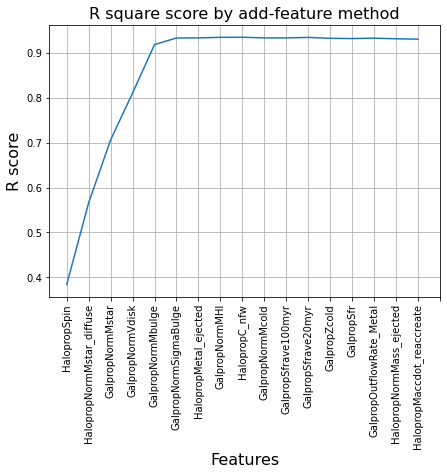

Elapsed time to run the target_predicting_RF_function: 18495.284 seconds
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.951, test=0.895) total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.955, test=0.900) total time=  18.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.984, test=0.938) total time=  18.2s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.736, test=0.714) total time=  10.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.956, test=0.901) total time=  17.9s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.720, test=0.703) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.898) total time=   3.5s

[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.737, test=0.706) total time=   4.9s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.950, test=0.898) total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.955, test=0.895) total time=  18.1s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.729, test=0.700) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.949, test=0.895) total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.956, test=0.898) total time=   8.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.927) total time=  11.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.956, test=0.899) total time=  20.4s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.737, test=0.724) total time=  11.7s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.957, test=0.904) total time=  20.4s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.727, test=0.722) total time=   5.8s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.956, test=0.903) total time=  10.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.984, test=0.926) total time=  14.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.726, test=0.701) total time=   2.3s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators

[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.951, test=0.906) total time=  17.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.743, test=0.696) total time=  10.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.935) total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.983, test=0.934) total time=  11.7s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.726, test=0.707) total time=   5.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.955, test=0.885) total time=   8.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.985, test=0.915) total time=  12.0s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estima

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.982, test=0.920) total time=   5.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.985, test=0.934) total time=  13.7s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.735, test=0.728) total time=  11.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.934) total time=   5.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.987, test=0.921) total time=  13.6s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.737, test=0.708) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.953, test=0.898) total time=   4.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_esti

[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.733, test=0.700) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.732, test=0.698) total time=  11.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.983, test=0.920) total time=   5.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.932) total time=  23.2s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=20;, score=(train=0.746, test=0.727) total time=   2.3s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=20;, score=(train=0.946, test=0.893) total time=   4.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=100;, score=(train=0.952, test=0.886) total time=  20.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estim

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.982, test=0.937) total time=  11.9s
[CV 1/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=50;, score=(train=0.748, test=0.714) total time=   5.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=2, n_estimators=50;, score=(train=0.951, test=0.904) total time=   8.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.984, test=0.926) total time=   4.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=100;, score=(train=0.985, test=0.919) total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=5, min_samples_leaf=2, n_estimators=100;, score=(train=0.741, test=0.698) total time=  10.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=20;, score=(train=0.980, test=0.931) total time=   4.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_e

In [41]:
# Note: Running this function with all the 33 features and all the galaxies (~35,000) takes 5.2 hrs.
start_time = time.time()
target_predicting_RF_function(X, y, params = {})
elapsed_time = time.time() - start_time
print(f"Elapsed time to run the target_predicting_RF_function: {elapsed_time:.3f} seconds")



#### The ranking in this run is slightly different from the ranking in the previous run (see notebook v10) because the random_state in RandomForestRegressor is not fixed. However, the first 6 features are exactly the same in both runs - except for HaloprpNormMstar_diffuse, which has taken the 2nd place in feature ranking, where GalpropNormMstar_merge used to be previously. Looking at the Pearson Correlations Matrix above, we can see that these two features are strongly correlated (P=0.99).

LR Accuracy: 0.55 (+/- 0.14)


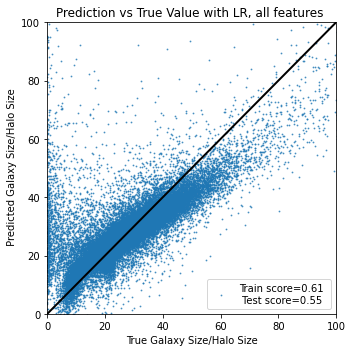

In [46]:
LR_results=target_predicting_LR_function(X,y)

In [ ]:
SVR_results=target_predicting_SVR_function(X,y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.950, test=0.927) total time= 7.7min
[CV 1/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.952, test=0.903) total time= 8.2min
[CV 3/3] END svr__C=1000, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.958, test=0.914) total time= 9.1min
Best params, best score: 0.9150 {'svr__C': 1000, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the GridSearchCV for SVR: 2759.163 seconds


### <font color='blue'> For comparison to the target_predicting_RF_function results above, see the RF results below from previous runs: 2.a. Random Forest (RF) - all features

In [15]:
regr_RF = RandomForestRegressor(random_state=0)

# number of trees in random forest
n_estimators = [20,50,100]

# create random grid
grid = {'bootstrap': [True],
               'max_depth': [5, 10, None],
#                'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
               'n_estimators': n_estimators}
# Grid search of parameters
rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

rfr_grid.fit(X, y)

print('Best params, best score:', "{:.4f}".format(rfr_grid.best_score_), \
    rfr_grid.best_params_)



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.9169 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}


In [16]:
best_RF=rfr_grid.best_estimator_ # The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

In [17]:
best_RF_trainscore=rfr_grid.cv_results_['mean_train_score'][rfr_grid.best_index_]

In [18]:
# predict y (galaxy sizes) by using 5-fold cross-validation
y_pred_RF = cross_val_predict(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [19]:
# find prediction scores of each of the cross validation fold
scores_RF = cross_val_score(best_RF, X, y, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [20]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_RF.mean(), scores_RF.std() * 2))

Accuracy: 0.92 (+/- 0.02)


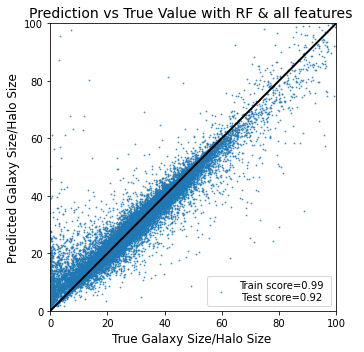

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
ax = plt.subplot()
ax.scatter(y, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
ax.set_xlim([0.0,100])
ax.set_ylim([0.0,100])
ax.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax.set_title('Prediction vs True Value with RF & all features ', fontsize=14)
ax.set_xlabel('True Galaxy Size/Halo Size ', fontsize=12)
ax.set_ylabel('Predicted Galaxy Size/Halo Size', fontsize=12)
ax.legend(loc='lower right')

fig.tight_layout()
# plt.savefig('Prediction_vs_True.jpeg', dpi=500)

plt.show()

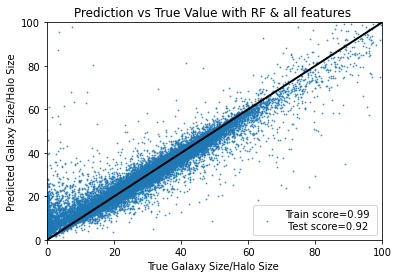

In [30]:
label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
plt.axis([0.0,100, 0.0,100])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Prediction vs True Value with RF & all features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel('Predicted Galaxy Size/Halo Size')
plt.legend(loc='lower right')
# plt.savefig('Prediction_vs_True.jpeg', dpi=500)
plt.show()

## <font color='red'> 2.b. Random Forest (RF) Feature Importance MDI & Permutation

In [32]:
start_time = time.time()
importances = rfr_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.028 seconds


Elapsed time to compute the importances: 33.098 seconds


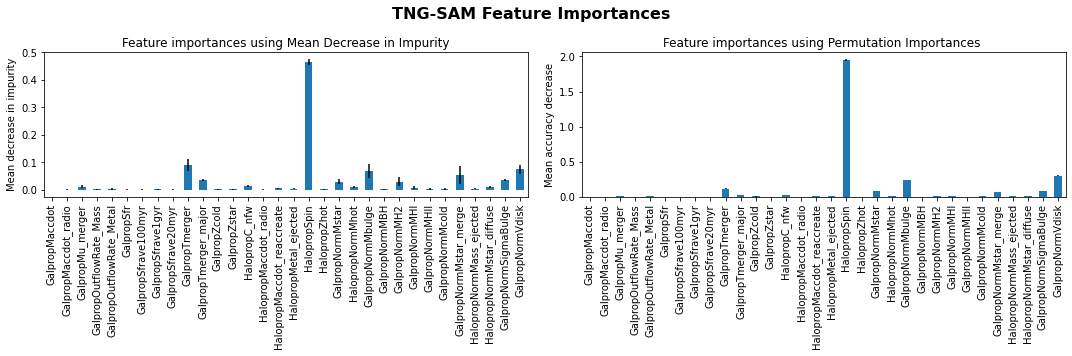

In [33]:

feature_names = X.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('TNG-SAM Feature Importances  ', fontsize=16, fontweight='bold')

forest_importances.plot.bar(yerr=std, ax=ax1)
ax1.set_title("Feature importances using Mean Decrease in Impurity")
ax1.set_ylabel("Mean decrease in impurity")
# plt.savefig("Feature_Importances_MDI.jpeg", dpi=500)

### Feature Importances Permutation


start_time = time.time()
result = permutation_importance(
    rfr_grid.best_estimator_, X, y, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

forest_importances.plot.bar(yerr=result.importances_std, ax=ax2)
ax2.set_title("Feature importances using Permutation Importances ")
ax2.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
# plt.savefig("Feature_Importances_v2.jpeg", dpi=500)

plt.show()

In [34]:
df_perm_import=pd.DataFrame(forest_importances).sort_values(0, ascending=False)

In [35]:
# 7 most important features that determine galaxy size
df_perm_import.head(7)

,0
HalopropSpin,1.947958
GalpropNormVdisk,0.300745
GalpropNormMbulge,0.236903
GalpropTmerger,0.113986
GalpropNormMstar,0.082063
GalpropNormSigmaBulge,0.078982
GalpropNormMstar_merge,0.069843


## <font color='darkviolet'> 2.c. Random Forest (RF) pipeline that determines min number of important features & their effect on R^2 score

### Add-column Feature Ranking

In [273]:
def run_random_search_pipeline(X, y):
    
    
#     n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]
#     grid = {'bootstrap': [True],
#                    'max_depth': [5, 10, None],
#     #                'max_features': ['auto', 'sqrt'],
#                    'min_samples_leaf': [1, 2, 4],
#     #                'min_samples_split': [2, 5, 10],
#                    'n_estimators': n_estimators}

    n_estimators = [20,50,100]
    grid = {'bootstrap': [True],
                   'max_depth': [5, 10, None],
    #                'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [2],
    #                'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    
#     pipeline = make_pipeline(RandomForestRegressor())
    model=RandomForestRegressor()

    reg_RF = GridSearchCV(model, grid, cv = KFold(n_splits=3, shuffle=True), \
                         verbose = 3, n_jobs = -1, return_train_score=True)
    reg_RF.fit(X, y)
#     estimator.get_params().keys()
    scores_lim = pd.DataFrame(reg_RF.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim['mean_test_score']

In [265]:
column_names = X.columns

In [268]:

def calculate_r_score(column_names):
    x_new = X[list(column_names)]
    # print(column_names)
    r_square = run_random_search_pipeline(x_new, y)
    
    return r_square.max()

In [269]:
def print_results(max_col_names, max_col_rscores):
    k= 1
    for i, j in zip(max_col_names, max_col_rscores):
        print("\t", k, i,j)
        k +=1

In [270]:
def calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i):
    r_score_dict = {}
    for column_names in tqdm(orj_column_names): # orj_column_names = original column names
        # count += 1
        # print(count, max_col_names , column_names)
        feature_list = max_col_names + [column_names]
        r_score = calculate_r_score(feature_list)
        r_score_dict[column_names] = r_score
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))
    # print("asdfasd", max_col_names[len(max_col_names) - 1])
    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    return max_col_names, max_col_rscores, orj_column_names, r_score_dict

In [271]:
# init
from tqdm import tqdm 
max_col_names = [] # 
max_col_rscores = []
orj_column_names = list(X.columns)

In [248]:
max_col_rscores

[0.23702288626295742, 0.48903965966816626]

[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=10;, score=(train=0.586, test=0.242) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=10;, score=(train=0.376, test=-0.023) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.400, test=-0.017) total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=30;, score=(train=0.852, test=0.481) total time=   1.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=10;, score=(train=0.592, test=0.221) total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=50;, score=(train=0.608, test=0.234) total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=10;, score=(train=0.381, test=-0.030) total time=   0.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_le

In [275]:
# main 
for i in range(1, len(orj_column_names)+1):
    max_col_names, max_col_rscores, orj_column_names, r_score_dict = \
        calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i)
        
    print(f"{i}. iteration: ")
    print_results(max_col_names, max_col_rscores)
    if i==17: break

  0%|                                                    | 0/32 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/32 [00:00<00:25,  1.19it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 2/32 [00:02<00:31,  1.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████▏                                       | 3/32 [00:08<01:39,  3.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▌                                      | 4/32 [00:13<01:53,  4.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|██████▉                                     | 5/32 [00:18<02:00,  4.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▎                                   | 6/32 [00:23<01:59,  4.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▋                                  | 7/32 [00:28<01:57,  4.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 8/32 [00:33<01:59,  4.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▍                               | 9/32 [00:38<01:54,  4.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▍                             | 10/32 [00:42<01:38,  4.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 34%|██████████████▊                            | 11/32 [00:44<01:18,  3.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▏                          | 12/32 [00:49<01:21,  4.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▍                         | 13/32 [00:54<01:27,  4.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|██████████████████▊                        | 14/32 [01:01<01:33,  5.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▏                      | 15/32 [01:02<01:06,  3.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 16/32 [01:08<01:11,  4.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▊                    | 17/32 [01:13<01:12,  4.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████▏                  | 18/32 [01:17<01:03,  4.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▌                 | 19/32 [01:22<01:01,  4.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 20/32 [01:28<00:58,  4.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 66%|████████████████████████████▏              | 21/32 [01:31<00:49,  4.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▌             | 22/32 [01:35<00:42,  4.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|██████████████████████████████▉            | 23/32 [01:35<00:28,  3.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 24/32 [01:39<00:26,  3.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▌         | 25/32 [01:43<00:24,  3.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▉        | 26/32 [01:47<00:21,  3.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████▎      | 27/32 [01:51<00:18,  3.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 28/32 [01:54<00:13,  3.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|██████████████████████████████████████▉    | 29/32 [01:59<00:11,  3.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▎  | 30/32 [02:00<00:06,  3.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▋ | 31/32 [02:05<00:03,  3.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 32/32 [02:08<00:00,  4.01s/it]


1. iteration: 
	 1 HalopropSpin 0.24174854754862443


  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/31 [00:03<01:51,  3.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 2/31 [00:11<02:51,  5.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▎                                       | 3/31 [00:18<03:04,  6.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▋                                      | 4/31 [00:25<03:03,  6.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|███████                                     | 5/31 [00:32<03:01,  6.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▌                                   | 6/31 [00:39<02:54,  6.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|█████████▉                                  | 7/31 [00:47<02:47,  7.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▎                                | 8/31 [00:54<02:41,  7.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▊                               | 9/31 [01:01<02:34,  7.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|█████████████▊                             | 10/31 [01:07<02:22,  6.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▎                           | 11/31 [01:12<02:07,  6.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|████████████████▋                          | 12/31 [01:19<02:05,  6.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████                         | 13/31 [01:27<02:03,  6.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▍                       | 14/31 [01:34<01:57,  6.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▊                      | 15/31 [01:41<01:53,  7.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▏                    | 16/31 [01:49<01:47,  7.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▌                   | 17/31 [01:56<01:41,  7.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|████████████████████████▉                  | 18/31 [02:03<01:32,  7.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▎                | 19/31 [02:10<01:25,  7.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▋               | 20/31 [02:17<01:17,  7.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 21/31 [02:24<01:09,  6.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▌            | 22/31 [02:31<01:04,  7.14s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▉           | 23/31 [02:38<00:57,  7.14s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████▎         | 24/31 [02:46<00:50,  7.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▋        | 25/31 [02:53<00:43,  7.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████       | 26/31 [03:00<00:35,  7.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▍     | 27/31 [03:07<00:27,  6.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▊    | 28/31 [03:14<00:21,  7.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▏  | 29/31 [03:20<00:13,  6.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 30/31 [03:27<00:06,  6.93s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 31/31 [03:34<00:00,  6.92s/it]


2. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/30 [00:06<03:10,  6.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|██▉                                         | 2/30 [00:15<03:46,  8.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 3/30 [00:25<03:58,  8.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▊                                      | 4/30 [00:34<03:56,  9.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 5/30 [00:44<03:50,  9.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 6/30 [00:53<03:43,  9.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████▎                                 | 7/30 [01:03<03:36,  9.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▋                                | 8/30 [01:12<03:26,  9.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 9/30 [01:21<03:15,  9.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▎                            | 10/30 [01:30<03:02,  9.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|███████████████▊                           | 11/30 [01:39<02:49,  8.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▏                         | 12/30 [01:48<02:42,  9.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▋                        | 13/30 [01:57<02:34,  9.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████                       | 14/30 [02:06<02:26,  9.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 15/30 [02:15<02:16,  9.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▉                    | 16/30 [02:25<02:08,  9.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▎                  | 17/30 [02:34<01:59,  9.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 18/30 [02:43<01:49,  9.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████▏               | 19/30 [02:52<01:40,  9.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 20/30 [03:01<01:30,  9.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████             | 21/30 [03:10<01:21,  9.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▌           | 22/30 [03:20<01:13,  9.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|████████████████████████████████▉          | 23/30 [03:29<01:04,  9.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 24/30 [03:38<00:55,  9.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 25/30 [03:47<00:46,  9.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▎     | 26/30 [03:57<00:36,  9.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▋    | 27/30 [04:06<00:28,  9.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|████████████████████████████████████████▏  | 28/30 [04:15<00:18,  9.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 29/30 [04:24<00:09,  9.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 30/30 [04:33<00:00,  9.10s/it]


3. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195


  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▌                                          | 1/29 [00:09<04:22,  9.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███                                         | 2/29 [00:21<04:49, 10.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▌                                       | 3/29 [00:33<04:54, 11.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████                                      | 4/29 [00:44<04:47, 11.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▌                                    | 5/29 [00:56<04:38, 11.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████                                   | 6/29 [01:08<04:29, 11.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▌                                 | 7/29 [01:20<04:18, 11.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▏                               | 8/29 [01:32<04:07, 11.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▋                              | 9/29 [01:44<03:55, 11.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 34%|██████████████▊                            | 10/29 [01:55<03:43, 11.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▎                          | 11/29 [02:07<03:30, 11.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▊                         | 12/29 [02:19<03:20, 11.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▎                       | 13/29 [02:31<03:09, 11.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▊                      | 14/29 [02:43<02:58, 11.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▏                    | 15/29 [02:54<02:45, 11.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▋                   | 16/29 [03:06<02:34, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▏                 | 17/29 [03:19<02:23, 11.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▋                | 18/29 [03:30<02:11, 11.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 66%|████████████████████████████▏              | 19/29 [03:42<01:58, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▋             | 20/29 [03:54<01:46, 11.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|███████████████████████████████▏           | 21/29 [04:06<01:35, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▌          | 22/29 [04:18<01:23, 11.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|██████████████████████████████████         | 23/29 [04:30<01:11, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▌       | 24/29 [04:42<00:59, 11.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|█████████████████████████████████████      | 25/29 [04:54<00:47, 11.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▌    | 26/29 [05:06<00:36, 12.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|████████████████████████████████████████   | 27/29 [05:18<00:23, 11.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 28/29 [05:30<00:11, 11.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 29/29 [05:41<00:00, 11.76s/it]


4. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▌                                          | 1/28 [00:10<04:56, 10.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███▏                                        | 2/28 [00:23<05:15, 12.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▋                                       | 3/28 [00:37<05:17, 12.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 4/28 [00:50<05:11, 12.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|███████▊                                    | 5/28 [01:04<05:01, 13.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▍                                  | 6/28 [01:17<04:50, 13.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 7/28 [01:30<04:38, 13.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 8/28 [01:44<04:25, 13.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|██████████████▏                             | 9/28 [01:57<04:13, 13.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|███████████████▎                           | 10/28 [02:10<03:58, 13.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|████████████████▉                          | 11/28 [02:23<03:42, 13.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▍                        | 12/28 [02:36<03:30, 13.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|███████████████████▉                       | 13/28 [02:50<03:18, 13.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 14/28 [03:03<03:05, 13.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████                    | 15/28 [03:16<02:51, 13.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▌                  | 16/28 [03:29<02:38, 13.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████                 | 17/28 [03:43<02:26, 13.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▋               | 18/28 [03:56<02:13, 13.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 19/28 [04:09<02:00, 13.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 20/28 [04:22<01:45, 13.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 21/28 [04:36<01:32, 13.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▊         | 22/28 [04:49<01:20, 13.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|███████████████████████████████████▎       | 23/28 [05:03<01:06, 13.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 24/28 [05:16<00:53, 13.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▍    | 25/28 [05:30<00:40, 13.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|███████████████████████████████████████▉   | 26/28 [05:43<00:26, 13.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▍ | 27/28 [05:56<00:13, 13.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 28/28 [06:10<00:00, 13.22s/it]


5. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▋                                          | 1/27 [00:13<05:38, 13.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███▎                                        | 2/27 [00:28<05:54, 14.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▉                                       | 3/27 [00:43<05:55, 14.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▌                                     | 4/27 [00:58<05:46, 15.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▏                                   | 5/27 [01:14<05:33, 15.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▊                                  | 6/27 [01:29<05:20, 15.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▍                                | 7/27 [01:45<05:06, 15.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████                               | 8/27 [02:00<04:51, 15.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 9/27 [02:16<04:36, 15.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|███████████████▉                           | 10/27 [02:31<04:21, 15.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▌                         | 11/27 [02:46<04:03, 15.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████                        | 12/27 [03:01<03:49, 15.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▋                      | 13/27 [03:17<03:34, 15.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▎                    | 14/27 [03:32<03:19, 15.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|███████████████████████▉                   | 15/27 [03:47<03:02, 15.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▍                 | 16/27 [04:02<02:47, 15.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████                | 17/27 [04:18<02:32, 15.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 18/27 [04:33<02:18, 15.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████▎            | 19/27 [04:49<02:03, 15.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▊           | 20/27 [05:04<01:47, 15.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▍         | 21/27 [05:19<01:32, 15.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|███████████████████████████████████        | 22/27 [05:35<01:17, 15.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▋      | 23/27 [05:50<01:01, 15.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▏    | 24/27 [06:06<00:46, 15.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|███████████████████████████████████████▊   | 25/27 [06:21<00:30, 15.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▍ | 26/27 [06:37<00:15, 15.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 27/27 [06:52<00:00, 15.28s/it]


6. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▋                                          | 1/26 [00:15<06:24, 15.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▍                                        | 2/26 [00:32<06:37, 16.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████                                       | 3/26 [00:50<06:33, 17.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▊                                     | 4/26 [01:08<06:21, 17.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▍                                   | 5/26 [01:25<06:07, 17.49s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████▏                                 | 6/26 [01:43<05:52, 17.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▊                                | 7/26 [02:01<05:36, 17.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▌                              | 8/26 [02:19<05:19, 17.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▏                            | 9/26 [02:37<05:02, 17.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                          | 10/26 [02:55<04:44, 17.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▏                        | 11/26 [03:12<04:23, 17.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|███████████████████▊                       | 12/26 [03:30<04:07, 17.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 13/26 [03:48<03:50, 17.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████▏                   | 14/26 [04:06<03:34, 17.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|████████████████████████▊                  | 15/26 [04:23<03:14, 17.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▍                | 16/26 [04:41<02:58, 17.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|████████████████████████████               | 17/26 [04:59<02:40, 17.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▊             | 18/26 [05:17<02:23, 17.94s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▍           | 19/26 [05:35<02:05, 17.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████          | 20/26 [05:53<01:46, 17.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▋        | 21/26 [06:11<01:29, 18.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▍      | 22/26 [06:29<01:11, 17.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|██████████████████████████████████████     | 23/26 [06:47<00:53, 17.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▋   | 24/26 [07:05<00:36, 18.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▎ | 25/26 [07:23<00:17, 17.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 26/26 [07:40<00:00, 17.73s/it]


7. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▊                                          | 1/25 [00:17<07:10, 17.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▌                                        | 2/25 [00:37<07:18, 19.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▎                                      | 3/25 [00:58<07:11, 19.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|███████                                     | 4/25 [01:18<06:57, 19.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 5/25 [01:38<06:40, 20.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▌                                 | 6/25 [01:58<06:21, 20.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▎                               | 7/25 [02:19<06:03, 20.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|██████████████                              | 8/25 [02:40<05:47, 20.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|███████████████▊                            | 9/25 [03:01<05:31, 20.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▏                         | 10/25 [03:22<05:13, 20.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|██████████████████▉                        | 11/25 [03:43<04:52, 20.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▋                      | 12/25 [04:05<04:33, 21.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▎                    | 13/25 [04:26<04:13, 21.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████                   | 14/25 [04:47<03:53, 21.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 15/25 [05:08<03:31, 21.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▌               | 16/25 [05:30<03:10, 21.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 17/25 [05:51<02:49, 21.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|██████████████████████████████▉            | 18/25 [06:12<02:29, 21.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▋          | 19/25 [06:34<02:08, 21.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 20/25 [06:55<01:47, 21.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████       | 21/25 [07:17<01:25, 21.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▊     | 22/25 [07:38<01:04, 21.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▌   | 23/25 [08:00<00:43, 21.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▎ | 24/25 [08:22<00:21, 21.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 25/25 [08:44<00:00, 20.97s/it]


8. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▊                                          | 1/24 [00:21<08:21, 21.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▋                                        | 2/24 [00:45<08:27, 23.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▌                                      | 3/24 [01:10<08:16, 23.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 4/24 [01:34<07:59, 23.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▏                                  | 5/24 [01:59<07:41, 24.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 6/24 [02:23<07:18, 24.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▊                               | 7/24 [02:48<06:55, 24.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 8/24 [03:12<06:31, 24.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                           | 9/24 [03:37<06:06, 24.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|█████████████████▉                         | 10/24 [04:02<05:43, 24.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|███████████████████▋                       | 11/24 [04:25<05:15, 24.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 12/24 [04:50<04:50, 24.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████▎                   | 13/24 [05:14<04:26, 24.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|█████████████████████████                  | 14/24 [05:38<04:02, 24.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 15/24 [06:02<03:36, 24.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 16/24 [06:26<03:12, 24.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▍            | 17/24 [06:50<02:48, 24.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 18/24 [07:14<02:24, 24.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|██████████████████████████████████         | 19/24 [07:38<02:00, 24.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 20/24 [08:02<01:36, 24.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 21/24 [08:26<01:12, 24.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▍   | 22/24 [08:50<00:48, 24.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▏ | 23/24 [09:14<00:23, 23.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 24/24 [09:38<00:00, 24.10s/it]


9. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▉                                          | 1/23 [00:24<08:52, 24.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|███▊                                        | 2/23 [00:50<08:51, 25.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▋                                      | 3/23 [01:16<08:35, 25.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▋                                    | 4/23 [01:43<08:15, 26.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▌                                  | 5/23 [02:09<07:52, 26.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▍                                | 6/23 [02:36<07:27, 26.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▍                              | 7/23 [03:02<07:01, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▎                            | 8/23 [03:28<06:34, 26.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|█████████████████▏                          | 9/23 [03:55<06:08, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▋                        | 10/23 [04:21<05:43, 26.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▌                      | 11/23 [04:48<05:16, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▍                    | 12/23 [05:14<04:49, 26.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▎                  | 13/23 [05:40<04:24, 26.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▏                | 14/23 [06:07<03:57, 26.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|████████████████████████████               | 15/23 [06:33<03:31, 26.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|█████████████████████████████▉             | 16/23 [07:00<03:04, 26.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▊           | 17/23 [07:26<02:38, 26.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▋         | 18/23 [07:52<02:12, 26.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▌       | 19/23 [08:19<01:45, 26.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▍     | 20/23 [08:45<01:19, 26.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████▎   | 21/23 [09:12<00:52, 26.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▏ | 22/23 [09:38<00:26, 26.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 23/23 [10:05<00:00, 26.32s/it]


10. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██                                          | 1/22 [00:26<09:08, 26.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████                                        | 2/22 [00:52<08:46, 26.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████                                      | 3/22 [01:19<08:21, 26.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|████████                                    | 4/22 [01:45<07:56, 26.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████                                  | 5/22 [02:12<07:30, 26.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|████████████                                | 6/22 [02:38<07:03, 26.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|██████████████                              | 7/22 [03:04<06:35, 26.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|████████████████                            | 8/22 [03:31<06:09, 26.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|██████████████████                          | 9/22 [03:58<05:45, 26.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▌                       | 10/22 [04:24<05:16, 26.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 11/22 [04:50<04:49, 26.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▍                   | 12/22 [05:16<04:23, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▍                 | 13/22 [05:42<03:56, 26.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▎               | 14/22 [06:09<03:30, 26.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▎             | 15/22 [06:35<03:04, 26.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▎           | 16/22 [07:02<02:38, 26.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████▏         | 17/22 [07:28<02:11, 26.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|███████████████████████████████████▏       | 18/22 [07:54<01:45, 26.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|█████████████████████████████████████▏     | 19/22 [08:21<01:19, 26.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████    | 20/22 [08:47<00:52, 26.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|█████████████████████████████████████████  | 21/22 [09:13<00:26, 26.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 22/22 [09:40<00:00, 26.38s/it]


11. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██                                          | 1/21 [00:28<09:35, 28.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▏                                       | 2/21 [00:57<09:07, 28.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 3/21 [01:26<08:39, 28.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▍                                   | 4/21 [01:55<08:09, 28.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▍                                 | 5/21 [02:24<07:41, 28.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 6/21 [02:53<07:12, 28.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 7/21 [03:21<06:42, 28.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▊                           | 8/21 [03:50<06:15, 28.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▊                         | 9/21 [04:19<05:45, 28.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▍                      | 10/21 [04:48<05:16, 28.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▌                    | 11/21 [05:16<04:47, 28.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▌                  | 12/21 [05:45<04:17, 28.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▌                | 13/21 [06:13<03:49, 28.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 14/21 [06:42<03:20, 28.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 15/21 [07:11<02:52, 28.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.007, test=-0.002) total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.060, test=-0.004) total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.522, test=-0.175) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.510, test=-0.201) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.505, test=-0.183) total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.077, test=-0.023) total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.515, test=-0.193) total time=   2

 76%|████████████████████████████████▊          | 16/21 [07:39<02:23, 28.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▊        | 17/21 [08:08<01:54, 28.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 18/21 [08:37<01:26, 28.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▉    | 19/21 [09:06<00:57, 28.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▉  | 20/21 [09:34<00:28, 28.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 21/21 [10:03<00:00, 28.76s/it]


12. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██▏                                         | 1/20 [00:30<09:46, 30.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 2/20 [01:01<09:17, 31.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▌                                     | 3/20 [01:32<08:46, 31.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 4/20 [02:04<08:16, 31.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 5/20 [02:35<07:45, 31.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 6/20 [03:06<07:15, 31.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▍                            | 7/20 [03:37<06:43, 31.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▌                          | 8/20 [04:08<06:14, 31.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▊                        | 9/20 [04:40<05:43, 31.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 10/20 [05:11<05:11, 31.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▋                   | 11/20 [05:42<04:39, 31.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 12/20 [06:12<04:08, 31.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▉               | 13/20 [06:44<03:37, 31.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████             | 14/20 [07:15<03:06, 31.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 15/20 [07:46<02:35, 31.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 16/20 [08:17<02:04, 31.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▌      | 17/20 [08:49<01:34, 31.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▋    | 18/20 [09:20<01:02, 31.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▊  | 19/20 [09:52<00:31, 31.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 20/20 [10:24<00:00, 31.20s/it]


13. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678


  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██▎                                         | 1/19 [00:33<10:05, 33.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▋                                       | 2/19 [01:07<09:33, 33.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|██████▉                                     | 3/19 [01:41<09:02, 33.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▎                                  | 4/19 [02:15<08:28, 33.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▌                                | 5/19 [02:49<07:54, 33.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|█████████████▉                              | 6/19 [03:23<07:19, 33.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|████████████████▏                           | 7/19 [03:57<06:46, 33.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▌                         | 8/19 [04:31<06:14, 34.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▊                       | 9/19 [05:05<05:39, 33.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▋                    | 10/19 [05:39<05:05, 33.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|████████████████████████▉                  | 11/19 [06:12<04:31, 33.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████▏               | 12/19 [06:46<03:57, 33.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▍             | 13/19 [07:20<03:23, 33.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▋           | 14/19 [07:54<02:49, 33.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▉         | 15/19 [08:28<02:15, 33.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████▏      | 16/19 [09:02<01:41, 33.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▍    | 17/19 [09:37<01:08, 34.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▋  | 18/19 [10:11<00:34, 34.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 19/19 [10:45<00:00, 33.96s/it]


14. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678
	 14 GalpropMaccdot_radio 0.9300046825844696


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▍                                         | 1/18 [00:36<10:15, 36.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▉                                       | 2/18 [01:12<09:39, 36.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 3/18 [01:48<09:04, 36.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▊                                  | 4/18 [02:24<08:26, 36.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▏                               | 5/18 [03:01<07:50, 36.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 6/18 [03:37<07:16, 36.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|█████████████████                           | 7/18 [04:14<06:40, 36.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████▌                        | 8/18 [04:50<06:03, 36.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 9/18 [05:26<05:26, 36.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|███████████████████████▉                   | 10/18 [06:02<04:49, 36.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▎                | 11/18 [06:38<04:13, 36.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 12/18 [07:14<03:37, 36.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|███████████████████████████████            | 13/18 [07:51<03:01, 36.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▍         | 14/18 [08:27<02:24, 36.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 15/18 [09:03<01:48, 36.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▏    | 16/18 [09:40<01:12, 36.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▌  | 17/18 [10:16<00:36, 36.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 18/18 [10:52<00:00, 36.25s/it]


15. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678
	 14 GalpropMaccdot_radio 0.9300046825844696
	 15 HalopropNormMass_ejected 0.928832827037053


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  12.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  13.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.931) total time=  13.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.935) total time=  13.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.942) total time=  13.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  13.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  13.1s
[CV

  6%|██▌                                         | 1/17 [00:39<10:28, 39.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▏                                      | 2/17 [01:18<09:45, 39.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|███████▊                                    | 3/17 [01:56<09:03, 38.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▎                                 | 4/17 [02:35<08:23, 38.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▉                               | 5/17 [03:14<07:45, 38.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▌                            | 6/17 [03:53<07:07, 38.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|██████████████████                          | 7/17 [04:32<06:28, 38.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▋                       | 8/17 [05:11<05:50, 38.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|███████████████████████▎                    | 9/17 [05:49<05:10, 38.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▎                 | 10/17 [06:28<04:30, 38.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▊               | 11/17 [07:06<03:52, 38.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▎            | 12/17 [07:45<03:13, 38.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.488, test=-0.228) total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.553, test=-0.104) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.513, test=-0.206) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.533, test=-0.176) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.519, test=-0.205) total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.058, test=-0.002) total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.515, test=-0.188) total time=   2

 76%|████████████████████████████████▉          | 13/17 [08:24<02:35, 38.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|███████████████████████████████████▍       | 14/17 [09:03<01:56, 38.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▉     | 15/17 [09:42<01:17, 38.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▍  | 16/17 [10:21<00:38, 38.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 17/17 [11:00<00:00, 38.83s/it]


16. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678
	 14 GalpropMaccdot_radio 0.9300046825844696
	 15 HalopropNormMass_ejected 0.928832827037053
	 16 GalpropSfrave1gyr 0.9289532014437741


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 1/16 [00:41<10:18, 41.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.528, test=-0.172) total time=   1.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.512, test=-0.184) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.529, test=-0.165) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.518, test=-0.170) total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.517, test=-0.219) total time=   1.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.393, test=-0.000) total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.229, test=-0.058) total time=   1

 12%|█████▌                                      | 2/16 [01:22<09:41, 41.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▎                                   | 3/16 [02:04<08:57, 41.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 4/16 [02:45<08:15, 41.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▊                              | 5/16 [03:26<07:35, 41.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                           | 6/16 [04:08<06:54, 41.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████▎                        | 7/16 [04:49<06:12, 41.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 8/16 [05:31<05:31, 41.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████▊                   | 9/16 [06:11<04:48, 41.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 10/16 [06:53<04:07, 41.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▌             | 11/16 [07:34<03:26, 41.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 12/16 [08:16<02:45, 41.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▉        | 13/16 [08:57<02:03, 41.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 14/16 [09:38<01:22, 41.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.006, test=-0.002) total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.060, test=-0.003) total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.528, test=-0.193) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.552, test=-0.129) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.515, test=-0.191) total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.503, test=-0.175) total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.508, test=-0.189) total time=   2

 94%|████████████████████████████████████████▎  | 15/16 [10:20<00:41, 41.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


100%|███████████████████████████████████████████| 16/16 [11:01<00:00, 41.34s/it]

17. iteration: 
	 1 HalopropSpin 0.24174854754862443
	 2 GalpropNormMstar_merge 0.5196900658536073
	 3 GalpropNormMstar 0.690816840778195
	 4 GalpropNormVdisk 0.8140150975366893
	 5 GalpropNormMbulge 0.9150249382216695
	 6 GalpropNormSigmaBulge 0.9288901480642253
	 7 HalopropMaccdot_reaccreate 0.9305932670570808
	 8 GalpropNormMcold 0.9302975365157599
	 9 GalpropZcold 0.9309567227184948
	 10 GalpropMaccdot 0.9315000991218478
	 11 GalpropSfr 0.9303442081264311
	 12 GalpropNormMHI 0.9307282639457354
	 13 HalopropC_nfw 0.9291917781211678
	 14 GalpropMaccdot_radio 0.9300046825844696
	 15 HalopropNormMass_ejected 0.928832827037053
	 16 GalpropSfrave1gyr 0.9289532014437741
	 17 GalpropSfrave100myr 0.9272269585925237


[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  16.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.936) total time=  16.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.924) total time=  16.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  16.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  17.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  16.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  17.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.007, test=-0.001) total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.484, test=-0.246) total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.534, test=-0.153) total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.506, test=-0.172) total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.512, test=-0.200) total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.516, test=-0.233) total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.524, test=-0.230) total time=   2.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_sample

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.933) total time=  16.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.922) total time=  16.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.924) total time=  17.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.931) total time=  17.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.907) total time=  17.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.927) total time=  17.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.922) total time=  18.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=

### Add-column results when GridSearch with hyperparameter tuning is applied

In [19]:
df_normalized['GalpropMaccdot'].count

<bound method Series.count of 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
35385    0.0
35386    0.0
35387    0.0
35388    0.0
35389    0.0
Name: GalpropMaccdot, Length: 35390, dtype: float64>

In [160]:
df_max_r_scores = pd.DataFrame({
    'feature_number' : range(1,18),
    'features':max_col_names,
    'r_sq_score': max_col_rscores  })

In [282]:
df_max_r_scores

,feature_number,features,r_sq_score
0,1,HalopropSpin,0.383211
1,2,GalpropNormMstar_merge,0.569557
2,3,GalpropNormMstar,0.705899
3,4,GalpropNormVdisk,0.809368
4,5,GalpropNormMbulge,0.915333
5,6,GalpropNormSigmaBulge,0.927868
6,7,HalopropNormMstar_diffuse,0.932271
7,8,GalpropMaccdot_radio,0.932349
8,9,HalopropMetal_ejected,0.932192
9,10,GalpropZstar,0.931228


In [167]:
# Save the important feature ranking obtained by add-column method
#df_max_r_scores.to_csv('Max r scores by add column method.csv', index=False)

In [21]:
df_max_r_scores

,feature_number,features,r_sq_score
0,1,HalopropSpin,0.383211
1,2,GalpropNormMstar_merge,0.569557
2,3,GalpropNormMstar,0.705899
3,4,GalpropNormVdisk,0.809368
4,5,GalpropNormMbulge,0.915333
5,6,GalpropNormSigmaBulge,0.927868
6,7,HalopropNormMstar_diffuse,0.932271
7,8,GalpropMaccdot_radio,0.932349
8,9,HalopropMetal_ejected,0.932192
9,10,GalpropZstar,0.931228


In [19]:
# df_max_r_scores=pd.read_csv('Max r scores by add column method.csv')

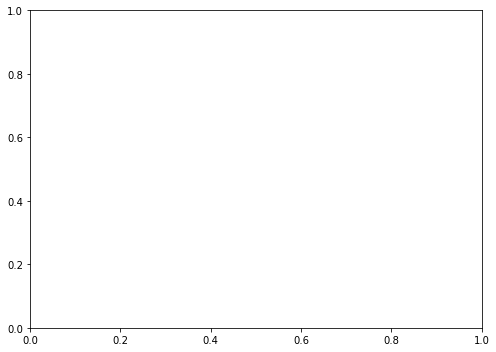

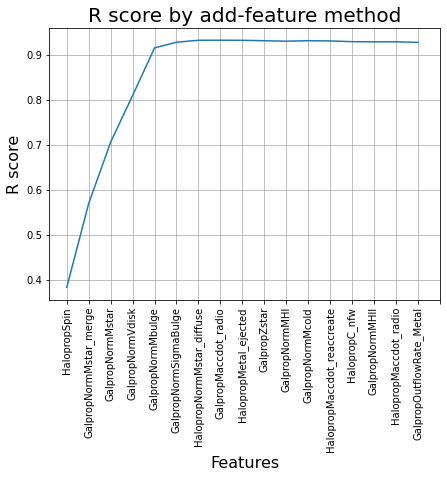

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                   legend=False, grid=True,
                    
                    xticks=range(0,18))

ax.set_title('R score by add-feature method', fontsize=20)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('R score', fontsize=16)

fig.tight_layout()
# plt.savefig('R scores.pdf', dpi=500)

plt.show()

Text(0, 0.5, 'R score')

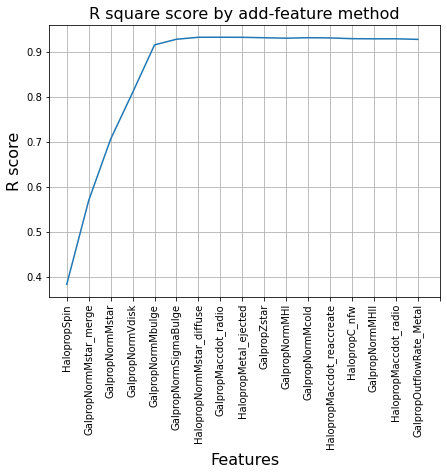

In [34]:
fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,18))
fig_add_feature.set_title(label= 'R square score by add-feature method',fontsize=16)
fig_add_feature.set_xlabel('Features',fontsize=16)
fig_add_feature.set_ylabel('R score',fontsize=16)


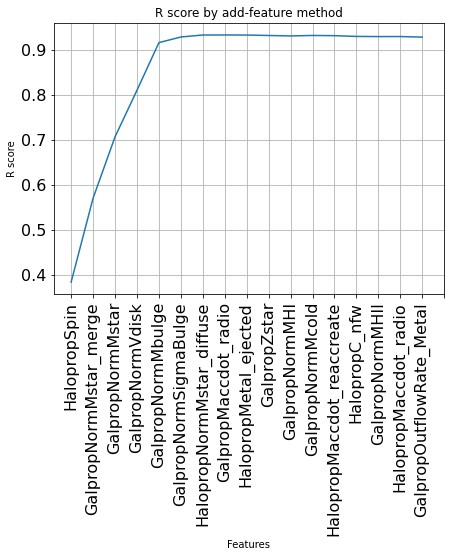

In [30]:
fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    title='R score by add-feature method', legend=False, grid=True,
                    xlabel='Features', ylabel = 'R score',
                    xticks=range(0,18), fontsize=16)
# fig_add_feature.set_title(title= 'R square score by add-feature method',pad=20, fontdict={'fontsize':24})
# fig_add_feature.set_ylabel('counts',fontdict={'fontsize':24})

In [35]:
# fig_add_feature.get_figure().savefig('R score by add-feature method.jpg', dpi=500)

### Drop-column Feature Ranking


In [286]:
def run_grid_search_pipeline(X, y, grid, model):
    

    n_estimators = [20,50,100]
    grid = {'bootstrap': [True],
                   'max_depth': [5, 10, None],
    #                'max_features': ['auto', 'sqrt'],
#                    'min_samples_leaf': [1, 2, 4],
    #                'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
        
#     n_estimators = [int(x) for x in np.linspace(start = 80, stop = 100, num = 1)]
#     grid = {'bootstrap': [True],
#                    'max_depth': [None],
#     #                'max_features': ['auto', 'sqrt'],
#                    'min_samples_leaf': [2],
#     #                'min_samples_split': [2, 5, 10],
#                    'n_estimators': n_estimators}


    model=RandomForestRegressor()

    model = GridSearchCV(model, grid, cv = KFold(n_splits=3, shuffle=True), \
                         verbose = 3, n_jobs = -1, return_train_score=True)
    model.fit(X, y)
#     estimator.get_params().keys()
    scores_lim = pd.DataFrame(reg_RF.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim['mean_test_score']

IndentationError: unexpected indent (3281605974.py, line 5)

In [288]:
X_new_dc=X # X new for drop column

df_grid= pd.DataFrame(columns= X_new_dc.columns)
index = 0
while len(X_new_dc.columns)>=0:
    

    for col_names in tqdm(X_new_dc.columns):
    
        X_changed = X_new_dc.drop(columns=[col_names])
        
        r_square = run_random_search_pipeline(X_changed, y)
        
        df_grid.loc[index,col_names] = r_square.max() # store the corresponding max r_square to the name of the removed column
        
    X_new_dc.drop(columns= [df_grid.iloc[index,:].astype('float64').idxmax()], inplace=True) # drop the column with the highest
    # R^2 value as that means that removing the feature of that coulmn doesn't decrease the performance of the
    # model; hence the features is 'not important'
    
    index+=1
        
    




  0%|                                                    | 0/32 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/32 [01:17<39:52, 77.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 2/32 [02:31<37:43, 75.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████▏                                       | 3/32 [03:44<35:58, 74.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▌                                      | 4/32 [04:58<34:38, 74.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.904) total time=  30.8s


 16%|██████▉                                     | 5/32 [06:12<33:18, 74.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▎                                   | 6/32 [07:25<31:54, 73.64s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▋                                  | 7/32 [08:38<30:39, 73.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 8/32 [09:51<29:22, 73.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▍                               | 9/32 [11:04<28:05, 73.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.902) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.904) total time=  28.9s


 31%|█████████████▍                             | 10/32 [12:17<26:46, 73.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 34%|██████████████▊                            | 11/32 [13:29<25:29, 72.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.905) total time=  28.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.916) total time=  28.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.921) total time=  28.9s


 38%|████████████████▏                          | 12/32 [14:42<24:17, 72.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▍                         | 13/32 [15:55<23:04, 72.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|██████████████████▊                        | 14/32 [17:08<21:52, 72.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▏                      | 15/32 [18:21<20:42, 73.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 16/32 [19:34<19:28, 73.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.911) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.915) total time=  29.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.913) total time=  28.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.905) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.914) total time=  28.8s


 53%|██████████████████████▊                    | 17/32 [20:48<18:17, 73.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.913) total time=  28.6s


 56%|████████████████████████▏                  | 18/32 [22:10<17:42, 75.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.923) total time=  28.6s


 59%|█████████████████████████▌                 | 19/32 [23:23<16:17, 75.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 20/32 [24:37<14:55, 74.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 66%|████████████████████████████▏              | 21/32 [25:50<13:36, 74.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.911) total time=  29.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.917) total time=  29.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.905) total time=  29.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  28.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.903) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.911) total time=  28.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.913) total time=  28.5s
[CV

 69%|█████████████████████████████▌             | 22/32 [27:05<12:24, 74.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|██████████████████████████████▉            | 23/32 [28:18<11:06, 74.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 24/32 [29:32<09:51, 73.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▌         | 25/32 [30:45<08:37, 73.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▉        | 26/32 [31:59<07:21, 73.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.909) total time=  28.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.979, test=0.891) total time=  29.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.896) total time=  28.9s


 84%|████████████████████████████████████▎      | 27/32 [33:12<06:07, 73.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.907) total time=  29.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.906) total time=  29.4s


 88%|█████████████████████████████████████▋     | 28/32 [34:26<04:54, 73.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|██████████████████████████████████████▉    | 29/32 [35:42<03:43, 74.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▎  | 30/32 [36:56<02:28, 74.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▋ | 31/32 [38:10<01:14, 74.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/31 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.907) total time=  28.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.915) total time=  29.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.914) total time=  29.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.900) total time=  29.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.916) total time=  32.2s


  3%|█▍                                          | 1/31 [01:13<36:39, 73.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.902) total time=  29.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.900) total time=  28.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  29.5s


  6%|██▊                                         | 2/31 [02:24<34:52, 72.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▎                                       | 3/31 [03:36<33:38, 72.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▋                                      | 4/31 [04:48<32:18, 71.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|███████                                     | 5/31 [05:59<31:06, 71.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▌                                   | 6/31 [07:10<29:49, 71.57s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.923) total time=  29.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.979, test=0.909) total time=  29.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.899) total time=  30.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.908) total time=  29.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.914) total time=  28.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.911) total time=  28.6s


 23%|█████████▉                                  | 7/31 [08:22<28:35, 71.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▎                                | 8/31 [09:33<27:23, 71.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.903) total time=  28.9s


 29%|████████████▊                               | 9/31 [10:44<26:11, 71.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|█████████████▊                             | 10/31 [11:56<24:59, 71.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▎                           | 11/31 [13:07<23:49, 71.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|████████████████▋                          | 12/31 [14:19<22:40, 71.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████                         | 13/31 [15:32<21:32, 71.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  28.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.910) total time=  28.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.898) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.917) total time=  28.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  28.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.919) total time=  28.4s


 45%|███████████████████▍                       | 14/31 [16:43<20:17, 71.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.903) total time=  28.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.909) total time=  28.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.905) total time=  28.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.917) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.904) total time=  28.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.912) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.966, test=0.861) total time=  34.1s
[CV

 48%|████████████████████▊                      | 15/31 [17:55<19:06, 71.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▏                    | 16/31 [19:06<17:53, 71.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.895) total time=  29.5s


 55%|███████████████████████▌                   | 17/31 [20:23<17:05, 73.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.903) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.893) total time=  28.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.915) total time=  28.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.918) total time=  28.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.920) total time=  28.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  28.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.907) total time=  28.3s


 58%|████████████████████████▉                  | 18/31 [21:34<15:42, 72.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▎                | 19/31 [22:45<14:26, 72.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▋               | 20/31 [23:56<13:09, 71.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 21/31 [25:09<12:01, 72.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▌            | 22/31 [26:20<10:46, 71.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▉           | 23/31 [27:31<09:32, 71.57s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.925) total time=  28.1s


 77%|█████████████████████████████████▎         | 24/31 [28:42<08:19, 71.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▋        | 25/31 [29:53<07:07, 71.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.885) total time=  29.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.918) total time=  28.4s


 84%|████████████████████████████████████       | 26/31 [31:04<05:56, 71.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.906) total time=  31.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.908) total time=  28.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.921) total time=  28.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.915) total time=  28.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  28.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.902) total time=  28.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.903) total time=  28.8s
[CV

 87%|█████████████████████████████████████▍     | 27/31 [32:15<04:44, 71.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▊    | 28/31 [33:27<03:33, 71.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▏  | 29/31 [34:38<02:22, 71.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.923) total time=  28.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.920) total time=  31.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.920) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.912) total time=  29.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.914) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.924) total time=  28.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.927) total time=  28.6s
[CV

 97%|█████████████████████████████████████████▌ | 30/31 [35:50<01:11, 71.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/30 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▍                                          | 1/30 [01:11<34:19, 71.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|██▉                                         | 2/30 [02:19<32:32, 69.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 3/30 [03:28<31:05, 69.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.913) total time=  28.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.914) total time=  29.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.919) total time=  28.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.907) total time=  28.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.910) total time=  28.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.899) total time=  29.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.921) total time=  28.7s
[CV

 13%|█████▊                                      | 4/30 [04:36<29:51, 68.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 5/30 [05:45<28:38, 68.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 6/30 [06:53<27:29, 68.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████▎                                 | 7/30 [08:02<26:20, 68.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▋                                | 8/30 [09:11<25:11, 68.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 9/30 [10:20<24:03, 68.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▎                            | 10/30 [11:27<22:47, 68.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|███████████████▊                           | 11/30 [12:36<21:39, 68.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▏                         | 12/30 [13:44<20:31, 68.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▋                        | 13/30 [14:53<19:25, 68.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.909) total time=  28.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.916) total time=  28.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.916) total time=  27.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.913) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.912) total time=  27.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.913) total time=  27.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.921) total time=  27.4s


 47%|████████████████████                       | 14/30 [16:02<18:20, 68.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 15/30 [17:11<17:11, 68.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▉                    | 16/30 [18:26<16:30, 70.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▎                  | 17/30 [19:35<15:11, 70.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 18/30 [20:44<13:56, 69.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████▏               | 19/30 [21:52<12:41, 69.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 20/30 [23:03<11:38, 69.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████             | 21/30 [24:12<10:24, 69.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.849) total time=  30.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.891) total time=  27.6s


 73%|███████████████████████████████▌           | 22/30 [25:20<09:12, 69.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|████████████████████████████████▉          | 23/30 [26:28<08:02, 68.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.920) total time=  28.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.907) total time=  28.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.902) total time=  28.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.919) total time=  28.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.928) total time=  28.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.885) total time=  28.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.910) total time=  28.4s
[CV

 80%|██████████████████████████████████▍        | 24/30 [27:37<06:52, 68.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 25/30 [28:45<05:43, 68.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▎     | 26/30 [29:54<04:34, 68.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▋    | 27/30 [31:02<03:25, 68.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|████████████████████████████████████████▏  | 28/30 [32:11<02:17, 68.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 29/30 [33:20<01:08, 68.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.967, test=0.857) total time=  30.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  28.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.904) total time=  28.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.913) total time=  28.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.902) total time=  28.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.912) total time=  28.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.909) total time=  28.6s
[CV

  0%|                                                    | 0/29 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  3%|█▌                                          | 1/29 [01:08<31:48, 68.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███                                         | 2/29 [02:14<30:10, 67.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▌                                       | 3/29 [03:20<28:53, 66.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████                                      | 4/29 [04:26<27:39, 66.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.926) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  26.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.917) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.909) total time=  27.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  27.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  27.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.916) total time=  27.5s
[CV

 17%|███████▌                                    | 5/29 [05:32<26:28, 66.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  27.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.909) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  27.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.918) total time=  27.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.886) total time=  27.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.907) total time=  27.5s
[CV

 21%|█████████                                   | 6/29 [06:39<25:26, 66.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▌                                 | 7/29 [07:46<24:28, 66.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.898) total time=  28.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  28.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  27.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.923) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.918) total time=  27.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.914) total time=  27.7s
[CV

 28%|████████████▏                               | 8/29 [08:53<23:19, 66.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▋                              | 9/29 [09:58<22:07, 66.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 34%|██████████████▊                            | 10/29 [11:03<20:50, 65.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.908) total time=  26.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.926) total time=  26.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.927) total time=  26.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.916) total time=  28.1s


 38%|████████████████▎                          | 11/29 [12:09<19:44, 65.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▊                         | 12/29 [13:15<18:38, 65.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▎                       | 13/29 [14:20<17:33, 65.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.923) total time=  26.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.920) total time=  26.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.911) total time=  26.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.913) total time=  26.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.924) total time=  25.8s


 48%|████████████████████▊                      | 14/29 [15:26<16:28, 65.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▏                    | 15/29 [16:32<15:22, 65.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  26.1s


 55%|███████████████████████▋                   | 16/29 [17:45<14:43, 67.94s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.917) total time=  26.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.909) total time=  25.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.918) total time=  26.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.917) total time=  26.4s


 59%|█████████████████████████▏                 | 17/29 [18:51<13:27, 67.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▋                | 18/29 [19:57<12:16, 67.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 66%|████████████████████████████▏              | 19/29 [21:03<11:05, 66.57s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▋             | 20/29 [22:11<10:04, 67.16s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|███████████████████████████████▏           | 21/29 [23:17<08:54, 66.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▌          | 22/29 [24:23<07:45, 66.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|██████████████████████████████████         | 23/29 [25:28<06:37, 66.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  25.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.976, test=0.886) total time=  27.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.976, test=0.900) total time=  27.3s


 83%|███████████████████████████████████▌       | 24/29 [26:34<05:30, 66.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|█████████████████████████████████████      | 25/29 [27:40<04:23, 65.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▌    | 26/29 [28:45<03:17, 65.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.878) total time=  26.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.921) total time=  26.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  26.3s


 93%|████████████████████████████████████████   | 27/29 [29:51<02:11, 65.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 97%|█████████████████████████████████████████▌ | 28/29 [30:58<01:06, 66.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/28 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▌                                          | 1/28 [01:05<29:38, 65.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.908) total time=  27.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  27.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.914) total time=  27.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.928) total time=  27.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.904) total time=  27.4s
[CV

  7%|███▏                                        | 2/28 [02:09<27:54, 64.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▋                                       | 3/28 [03:12<26:33, 63.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 4/28 [04:15<25:21, 63.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|███████▊                                    | 5/28 [05:18<24:17, 63.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▍                                  | 6/28 [06:21<23:14, 63.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 7/28 [07:24<22:09, 63.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 8/28 [08:28<21:05, 63.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  26.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  25.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.908) total time=  25.0s


 32%|██████████████▏                             | 9/28 [09:31<20:02, 63.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|███████████████▎                           | 10/28 [10:33<18:54, 63.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|████████████████▉                          | 11/28 [11:37<17:52, 63.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▍                        | 12/28 [12:40<16:52, 63.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.911) total time=  27.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.912) total time=  27.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.906) total time=  27.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  27.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.923) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.930) total time=  27.8s
[CV

 46%|███████████████████▉                       | 13/28 [13:43<15:48, 63.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 14/28 [14:47<14:48, 63.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████                    | 15/28 [15:50<13:43, 63.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▌                  | 16/28 [17:01<13:04, 65.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████                 | 17/28 [18:04<11:52, 64.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.920) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.907) total time=  27.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.914) total time=  25.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.927) total time=  25.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.913) total time=  25.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.912) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.917) total time=  25.3s
[CV

 64%|███████████████████████████▋               | 18/28 [19:07<10:44, 64.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 19/28 [20:10<09:35, 63.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 20/28 [21:17<08:37, 64.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 21/28 [22:20<07:29, 64.24s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▊         | 22/28 [23:23<06:23, 63.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.967, test=0.837) total time=  28.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.917) total time=  25.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.916) total time=  26.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.905) total time=  26.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  26.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  26.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  24.8s
[CV

 82%|███████████████████████████████████▎       | 23/28 [24:26<05:18, 63.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 24/28 [25:29<04:13, 63.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.921) total time=  25.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.923) total time=  26.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.915) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.911) total time=  26.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.924) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.922) total time=  26.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.933) total time=  26.0s
[CV

 89%|██████████████████████████████████████▍    | 25/28 [26:32<03:10, 63.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.929) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.921) total time=  25.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.907) total time=  25.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  25.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  25.3s


 93%|███████████████████████████████████████▉   | 26/28 [27:35<02:06, 63.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▍ | 27/28 [28:39<01:03, 63.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/27 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.912) total time=  25.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.915) total time=  25.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.934) total time=  24.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.932) total time=  25.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  25.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.968, test=0.832) total time=  27.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.920) total time=  25.1s
[CV

  4%|█▋                                          | 1/27 [01:03<27:21, 63.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███▎                                        | 2/27 [02:04<25:46, 61.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▉                                       | 3/27 [03:04<24:31, 61.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.922) total time=  27.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.897) total time=  27.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  27.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.918) total time=  26.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.922) total time=  26.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  26.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.921) total time=  26.1s
[CV

 15%|██████▌                                     | 4/27 [04:05<23:24, 61.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▏                                   | 5/27 [05:06<22:22, 61.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▊                                  | 6/27 [06:07<21:19, 60.94s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▍                                | 7/27 [07:08<20:18, 60.93s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████                               | 8/27 [08:08<19:16, 60.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.874) total time=  26.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.919) total time=  25.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  25.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.920) total time=  25.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.913) total time=  25.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.914) total time=  24.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  24.3s


 33%|██████████████▋                             | 9/27 [09:08<18:11, 60.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|███████████████▉                           | 10/27 [10:09<17:11, 60.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|█████████████████▌                         | 11/27 [11:10<16:09, 60.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████                        | 12/27 [12:10<15:09, 60.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.912) total time=  25.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.901) total time=  25.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.910) total time=  26.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.928) total time=  24.5s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  24.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  24.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.911) total time=  24.6s
[CV

 48%|████████████████████▋                      | 13/27 [13:11<14:09, 60.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▎                    | 14/27 [14:12<13:09, 60.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.916) total time=  24.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  24.3s


 56%|███████████████████████▉                   | 15/27 [15:19<12:32, 62.71s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▍                 | 16/27 [16:20<11:22, 62.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████                | 17/27 [17:21<10:18, 61.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 18/27 [18:22<09:13, 61.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████▎            | 19/27 [19:25<08:16, 62.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▊           | 20/27 [20:26<07:10, 61.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▍         | 21/27 [21:26<06:07, 61.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|███████████████████████████████████        | 22/27 [22:26<05:03, 60.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▋      | 23/27 [23:26<04:02, 60.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  25.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.921) total time=  24.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.914) total time=  24.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.920) total time=  24.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.924) total time=  24.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.915) total time=  23.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  24.4s
[CV

 89%|██████████████████████████████████████▏    | 24/27 [24:27<03:02, 60.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|███████████████████████████████████████▊   | 25/27 [25:27<02:01, 60.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▍ | 26/27 [26:28<01:00, 60.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/26 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▋                                          | 1/26 [01:01<25:37, 61.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▍                                        | 2/26 [02:00<23:54, 59.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.914) total time=  26.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.907) total time=  27.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.908) total time=  24.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  24.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.929) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.931) total time=  25.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.899) total time=  25.6s
[CV

 12%|█████                                       | 3/26 [02:57<22:34, 58.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▊                                     | 4/26 [03:57<21:42, 59.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▍                                   | 5/26 [04:57<20:47, 59.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.968, test=0.857) total time=  28.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.932) total time=  25.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.924) total time=  25.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.923) total time=  25.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  25.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  25.1s
[CV

 23%|██████████▏                                 | 6/26 [05:55<19:41, 59.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▊                                | 7/26 [06:54<18:42, 59.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▌                              | 8/26 [07:56<17:55, 59.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▏                            | 9/26 [08:54<16:47, 59.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                          | 10/26 [09:53<15:46, 59.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▏                        | 11/26 [10:51<14:43, 58.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|███████████████████▊                       | 12/26 [11:49<13:40, 58.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 13/26 [12:47<12:39, 58.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████▏                   | 14/26 [13:45<11:41, 58.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.909) total time=  25.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.910) total time=  24.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.920) total time=  24.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  24.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  24.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.930) total time=  24.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  24.3s
[CV

 58%|████████████████████████▊                  | 15/26 [14:49<11:01, 60.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▍                | 16/26 [15:47<09:54, 59.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|████████████████████████████               | 17/26 [16:45<08:50, 58.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▊             | 18/26 [17:45<07:54, 59.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▍           | 19/26 [18:43<06:52, 58.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████          | 20/26 [19:41<05:51, 58.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  24.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.915) total time=  24.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.918) total time=  23.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  24.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.920) total time=  23.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.919) total time=  23.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  23.0s
[CV

 81%|██████████████████████████████████▋        | 21/26 [20:39<04:51, 58.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▍      | 22/26 [21:37<03:52, 58.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|██████████████████████████████████████     | 23/26 [22:34<02:54, 58.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▋   | 24/26 [23:32<01:55, 57.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▎ | 25/26 [24:30<00:57, 57.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▊                                          | 1/25 [00:57<23:06, 57.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  24.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.916) total time=  24.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.841) total time=  27.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.901) total time=  24.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.974, test=0.899) total time=  25.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  24.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.909) total time=  24.0s
[CV

  8%|███▌                                        | 2/25 [01:53<21:41, 56.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  22.7s


 12%|█████▎                                      | 3/25 [02:49<20:33, 56.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|███████                                     | 4/25 [03:44<19:34, 55.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 5/25 [04:40<18:36, 55.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▌                                 | 6/25 [05:35<17:39, 55.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▎                               | 7/25 [06:31<16:40, 55.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  24.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.977, test=0.872) total time=  24.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.928) total time=  24.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.933) total time=  24.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  25.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  23.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.910) total time=  23.9s
[CV

 32%|██████████████                              | 8/25 [07:26<15:45, 55.60s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|███████████████▊                            | 9/25 [08:21<14:44, 55.29s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.924) total time=  22.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.843) total time=  25.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.979, test=0.900) total time=  23.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.979, test=0.872) total time=  23.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.916) total time=  22.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.923) total time=  22.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.920) total time=  23.6s
[CV

 40%|█████████████████▏                         | 10/25 [09:16<13:50, 55.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|██████████████████▉                        | 11/25 [10:12<12:54, 55.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▋                      | 12/25 [11:08<12:01, 55.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▎                    | 13/25 [12:03<11:05, 55.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████                   | 14/25 [13:04<10:28, 57.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.913) total time=  23.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.923) total time=  23.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.918) total time=  23.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.916) total time=  23.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.967, test=0.845) total time=  25.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.975, test=0.886) total time=  23.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  22.8s
[CV

 60%|█████████████████████████▊                 | 15/25 [13:59<09:26, 56.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▌               | 16/25 [14:55<08:26, 56.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▏             | 17/25 [15:53<07:33, 56.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|██████████████████████████████▉            | 18/25 [16:48<06:33, 56.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▋          | 19/25 [17:43<05:35, 55.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 20/25 [18:38<04:38, 55.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████       | 21/25 [19:34<03:42, 55.64s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▊     | 22/25 [20:29<02:46, 55.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▌   | 23/25 [21:24<01:50, 55.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▎ | 24/25 [22:20<00:55, 55.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/24 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▊                                          | 1/24 [00:54<20:54, 54.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▋                                        | 2/24 [01:47<19:37, 53.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.932) total time=  23.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.911) total time=  23.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.921) total time=  22.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.908) total time=  22.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.905) total time=  22.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.915) total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.930) total time=  22.1s
[CV

 12%|█████▌                                      | 3/24 [02:39<18:31, 52.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 4/24 [03:31<17:34, 52.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▏                                  | 5/24 [04:24<16:41, 52.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 6/24 [05:17<15:47, 52.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▊                               | 7/24 [06:09<14:52, 52.49s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 8/24 [07:01<13:59, 52.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                           | 9/24 [07:54<13:06, 52.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|█████████████████▉                         | 10/24 [08:46<12:13, 52.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  22.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.847) total time=  24.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.915) total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.890) total time=  22.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.922) total time=  22.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.910) total time=  22.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.924) total time=  20.9s
[CV

 46%|███████████████████▋                       | 11/24 [09:39<11:23, 52.60s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 12/24 [10:31<10:30, 52.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  21.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.930) total time=  21.5s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.920) total time=  21.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.931) total time=  21.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.966, test=0.848) total time=  24.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.929) total time=  21.8s
[CV

 54%|███████████████████████▎                   | 13/24 [11:29<09:54, 54.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|█████████████████████████                  | 14/24 [12:21<08:55, 53.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 15/24 [13:14<07:59, 53.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.910) total time=  25.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.930) total time=  23.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  22.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.926) total time=  23.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  25.3s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.927) total time=  23.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  23.4s
[CV

 67%|████████████████████████████▋              | 16/24 [14:09<07:10, 53.79s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.922) total time=  20.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.931) total time=  20.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.925) total time=  20.7s


 71%|██████████████████████████████▍            | 17/24 [15:01<06:13, 53.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 18/24 [15:54<05:18, 53.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|██████████████████████████████████         | 19/24 [16:46<04:24, 52.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 20/24 [17:39<03:31, 52.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 21/24 [18:31<02:37, 52.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.969, test=0.879) total time=  21.6s


 92%|███████████████████████████████████████▍   | 22/24 [19:24<01:45, 52.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▏ | 23/24 [20:16<00:52, 52.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/23 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  4%|█▉                                          | 1/23 [00:52<19:18, 52.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|███▊                                        | 2/23 [01:43<17:57, 51.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▋                                      | 3/23 [02:33<16:55, 50.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▋                                    | 4/23 [03:23<15:59, 50.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▌                                  | 5/23 [04:13<15:07, 50.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▍                                | 6/23 [05:03<14:15, 50.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▍                              | 7/23 [05:53<13:24, 50.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▎                            | 8/23 [06:44<12:34, 50.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|█████████████████▏                          | 9/23 [07:34<11:42, 50.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▋                        | 10/23 [08:24<10:52, 50.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 48%|████████████████████▌                      | 11/23 [09:14<10:02, 50.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▍                    | 12/23 [10:09<09:28, 51.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▎                  | 13/23 [10:59<08:31, 51.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▏                | 14/23 [11:49<07:38, 50.92s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|████████████████████████████               | 15/23 [12:42<06:50, 51.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|█████████████████████████████▉             | 16/23 [13:32<05:56, 50.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▊           | 17/23 [14:22<05:04, 50.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▋         | 18/23 [15:12<04:12, 50.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▌       | 19/23 [16:02<03:21, 50.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▍     | 20/23 [16:52<02:30, 50.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████▎   | 21/23 [17:42<01:40, 50.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 96%|█████████████████████████████████████████▏ | 22/23 [18:33<00:50, 50.27s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/22 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██                                          | 1/22 [00:49<17:26, 49.82s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████                                        | 2/22 [01:37<16:15, 48.76s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████                                      | 3/22 [02:25<15:15, 48.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|████████                                    | 4/22 [03:12<14:23, 47.97s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████                                  | 5/22 [04:00<13:34, 47.93s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|████████████                                | 6/22 [04:48<12:46, 47.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|██████████████                              | 7/22 [05:36<11:56, 47.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|████████████████                            | 8/22 [06:23<11:08, 47.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.931) total time=  22.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.927) total time=  21.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.920) total time=  21.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  21.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.978, test=0.913) total time=  22.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.929) total time=  21.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.932) total time=  21.9s
[CV

 41%|██████████████████                          | 9/22 [07:11<10:20, 47.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.926) total time=  21.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.975, test=0.880) total time=  22.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.982, test=0.930) total time=  22.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.916) total time=  21.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.917) total time=  20.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.936) total time=  20.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.921) total time=  20.8s
[CV

 45%|███████████████████▌                       | 10/22 [07:59<09:31, 47.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 11/22 [08:47<08:45, 47.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▍                   | 12/22 [09:39<08:13, 49.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▍                 | 13/22 [10:27<07:19, 48.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|███████████████████████████▎               | 14/22 [11:15<06:28, 48.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▎             | 15/22 [12:05<05:42, 48.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▎           | 16/22 [12:53<04:51, 48.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████▏         | 17/22 [13:41<04:02, 48.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.914) total time=  21.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.916) total time=  21.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.912) total time=  22.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.925) total time=  20.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.922) total time=  20.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.932) total time=  20.6s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.924) total time=  21.0s
[CV

 82%|███████████████████████████████████▏       | 18/22 [14:28<03:12, 48.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|█████████████████████████████████████▏     | 19/22 [15:16<02:23, 47.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████    | 20/22 [16:03<01:35, 47.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.927) total time=  20.7s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  21.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.934) total time=  19.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  20.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.967, test=0.858) total time=  22.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.881) total time=  20.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  20.0s
[CV

 95%|█████████████████████████████████████████  | 21/22 [16:51<00:47, 47.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/21 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██                                          | 1/21 [00:47<15:47, 47.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▏                                       | 2/21 [01:33<14:40, 46.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 3/21 [02:18<13:44, 45.78s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▍                                   | 4/21 [03:03<12:56, 45.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▍                                 | 5/21 [03:48<12:08, 45.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 6/21 [04:34<11:22, 45.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 7/21 [05:19<10:35, 45.40s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▊                           | 8/21 [06:04<09:49, 45.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▊                         | 9/21 [06:50<09:03, 45.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.927) total time=  19.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.928) total time=  18.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.927) total time=  17.9s


 48%|████████████████████▍                      | 10/21 [07:35<08:18, 45.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 52%|██████████████████████▌                    | 11/21 [08:20<07:33, 45.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|████████████████████████▌                  | 12/21 [09:11<07:02, 46.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▌                | 13/21 [09:56<06:11, 46.49s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 14/21 [10:44<05:27, 46.77s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 15/21 [11:29<04:37, 46.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▊          | 16/21 [12:14<03:49, 45.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▊        | 17/21 [12:59<03:02, 45.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 18/21 [13:44<02:16, 45.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▉    | 19/21 [14:29<01:30, 45.38s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▉  | 20/21 [15:15<00:45, 45.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██▏                                         | 1/20 [00:44<14:14, 44.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 2/20 [01:28<13:09, 43.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▌                                     | 3/20 [02:10<12:14, 43.22s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 4/20 [02:53<11:29, 43.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 5/20 [03:36<10:45, 43.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 6/20 [04:19<10:01, 42.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▍                            | 7/20 [05:01<09:17, 42.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.933) total time=  18.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.922) total time=  18.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.928) total time=  18.8s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.922) total time=  19.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.913) total time=  18.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.907) total time=  18.2s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.927) total time=  17.9s
[CV

 40%|█████████████████▌                          | 8/20 [05:44<08:34, 42.86s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|███████████████████▊                        | 9/20 [06:27<07:51, 42.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|█████████████████████▌                     | 10/20 [07:10<07:08, 42.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|███████████████████████▋                   | 11/20 [07:53<06:26, 42.90s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|█████████████████████████▊                 | 12/20 [08:41<05:54, 44.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▉               | 13/20 [09:24<05:07, 43.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████             | 14/20 [10:08<04:25, 44.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|████████████████████████████████▎          | 15/20 [10:51<03:38, 43.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 16/20 [11:34<02:53, 43.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▌      | 17/20 [12:16<02:09, 43.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|██████████████████████████████████████▋    | 18/20 [12:59<01:26, 43.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 95%|████████████████████████████████████████▊  | 19/20 [13:42<00:43, 43.05s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.920) total time=  20.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.932) total time=  19.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.929) total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  19.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.919) total time=  19.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.977, test=0.902) total time=  19.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.919) total time=  19.9s
[CV

  0%|                                                    | 0/19 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  5%|██▎                                         | 1/19 [00:42<12:48, 42.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|████▋                                       | 2/19 [01:23<11:45, 41.48s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 16%|██████▉                                     | 3/19 [02:03<10:56, 41.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▎                                  | 4/19 [02:44<10:12, 40.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 26%|███████████▌                                | 5/19 [03:24<09:29, 40.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 32%|█████████████▉                              | 6/19 [04:05<08:47, 40.57s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 37%|████████████████▏                           | 7/19 [04:45<08:06, 40.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▌                         | 8/19 [05:25<07:25, 40.51s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▊                       | 9/19 [06:06<06:44, 40.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|██████████████████████▋                    | 10/19 [06:46<06:03, 40.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 58%|████████████████████████▉                  | 11/19 [07:27<05:23, 40.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 63%|███████████████████████████▏               | 12/19 [08:11<04:51, 41.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 68%|█████████████████████████████▍             | 13/19 [08:52<04:07, 41.31s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 74%|███████████████████████████████▋           | 14/19 [09:37<03:32, 42.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▉         | 15/19 [10:17<02:47, 41.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 84%|████████████████████████████████████▏      | 16/19 [10:57<02:04, 41.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▍    | 17/19 [11:38<01:22, 41.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.923) total time=  24.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.910) total time=  24.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.908) total time=  23.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.909) total time=  24.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.907) total time=  25.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.923) total time=  23.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.909) total time=  23.6s
[CV

 95%|████████████████████████████████████████▋  | 18/19 [12:18<00:40, 40.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▍                                         | 1/18 [00:40<11:26, 40.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.919) total time=  18.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.927) total time=  16.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.932) total time=  17.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.973, test=0.848) total time=  17.6s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.926) total time=  16.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.910) total time=  17.7s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.936) total time=  16.1s
[CV

 11%|████▉                                       | 2/18 [01:19<10:32, 39.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 3/18 [01:57<09:42, 38.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|█████████▊                                  | 4/18 [02:35<09:00, 38.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 28%|████████████▏                               | 5/18 [03:14<08:20, 38.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 6/18 [03:52<07:41, 38.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 39%|█████████████████                           | 7/18 [04:30<07:02, 38.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████▌                        | 8/18 [05:08<06:22, 38.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 9/18 [05:46<05:44, 38.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|███████████████████████▉                   | 10/18 [06:25<05:06, 38.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 61%|██████████████████████████▎                | 11/18 [07:06<04:35, 39.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 12/18 [07:45<03:54, 39.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 72%|███████████████████████████████            | 13/18 [08:28<03:20, 40.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|█████████████████████████████████▍         | 14/18 [09:06<02:38, 39.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 15/18 [09:44<01:57, 39.14s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|██████████████████████████████████████▏    | 16/18 [10:22<01:17, 38.84s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▌  | 17/18 [11:00<00:38, 38.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▌                                         | 1/17 [00:38<10:09, 38.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▏                                      | 2/17 [01:14<09:13, 36.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|███████▊                                    | 3/17 [01:50<08:29, 36.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 24%|██████████▎                                 | 4/17 [02:25<07:50, 36.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.964, test=0.837) total time=  18.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.938) total time=  16.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.980, test=0.923) total time=  17.8s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  16.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.943) total time=  16.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.925) total time=  16.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.933) total time=  16.1s
[CV

 29%|████████████▉                               | 5/17 [03:01<07:12, 36.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 35%|███████████████▌                            | 6/17 [03:37<06:36, 36.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 41%|██████████████████                          | 7/17 [04:13<06:00, 36.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▋                       | 8/17 [04:49<05:23, 35.96s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|███████████████████████▎                    | 9/17 [05:25<04:47, 35.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 59%|█████████████████████████▎                 | 10/17 [06:01<04:12, 36.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 65%|███████████████████████████▊               | 11/17 [06:41<03:42, 37.11s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▎            | 12/17 [07:17<03:04, 36.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 76%|████████████████████████████████▉          | 13/17 [07:57<02:31, 37.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|███████████████████████████████████▍       | 14/17 [08:33<01:51, 37.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▉     | 15/17 [09:09<01:13, 36.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▍  | 16/17 [09:44<00:36, 36.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  6%|██▊                                         | 1/16 [00:35<08:55, 35.70s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▌                                      | 2/16 [01:09<08:03, 34.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 19%|████████▎                                   | 3/16 [01:42<07:22, 34.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 4/16 [02:16<06:45, 33.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▊                              | 5/16 [02:49<06:10, 33.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▌                           | 6/16 [03:23<05:35, 33.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|███████████████████▎                        | 7/16 [03:56<05:01, 33.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 8/16 [04:29<04:27, 33.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|████████████████████████▊                   | 9/16 [05:03<03:54, 33.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|██████████████████████████▉                | 10/16 [05:41<03:29, 34.98s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|█████████████████████████████▌             | 11/16 [06:15<02:53, 34.60s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.926) total time=  15.9s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.925) total time=  16.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.962, test=0.856) total time=  17.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.933) total time=  16.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.932) total time=  16.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.932) total time=  16.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.981, test=0.905) total time=  16.8s
[CV

 75%|████████████████████████████████▎          | 12/16 [06:53<02:22, 35.52s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 81%|██████████████████████████████████▉        | 13/16 [07:26<01:44, 34.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|█████████████████████████████████████▋     | 14/16 [07:59<01:08, 34.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 94%|████████████████████████████████████████▎  | 15/16 [08:33<00:34, 34.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|██▉                                         | 1/15 [00:33<07:47, 33.37s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 13%|█████▊                                      | 2/15 [01:04<06:59, 32.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 3/15 [01:36<06:22, 31.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|███████████▋                                | 4/15 [02:07<05:47, 31.61s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 5/15 [02:38<05:14, 31.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▌                          | 6/15 [03:09<04:41, 31.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 47%|████████████████████▌                       | 7/15 [03:40<04:09, 31.17s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 53%|███████████████████████▍                    | 8/15 [04:12<03:39, 31.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|██████████████████████████▍                 | 9/15 [04:46<03:14, 32.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|████████████████████████████▋              | 10/15 [05:18<02:40, 32.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|███████████████████████████████▌           | 11/15 [05:53<02:11, 32.93s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|██████████████████████████████████▍        | 12/15 [06:24<01:37, 32.39s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 87%|█████████████████████████████████████▎     | 13/15 [06:55<01:03, 31.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|████████████████████████████████████████▏  | 14/15 [07:26<00:31, 31.62s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/14 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  7%|███▏                                        | 1/14 [00:31<06:44, 31.13s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▎                                     | 2/14 [01:00<06:00, 30.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 21%|█████████▍                                  | 3/14 [01:29<05:23, 29.43s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▌                               | 4/14 [01:57<04:51, 29.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.987, test=0.929) total time=  12.3s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  12.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.974, test=0.885) total time=  12.4s


 36%|███████████████▋                            | 5/14 [02:26<04:21, 29.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|██████████████████▊                         | 6/14 [02:55<03:51, 28.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 7/14 [03:25<03:24, 29.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|█████████████████████████▏                  | 8/14 [03:57<03:00, 30.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|████████████████████████████▎               | 9/14 [04:26<02:28, 29.74s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|██████████████████████████████▋            | 10/14 [04:58<02:02, 30.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 79%|█████████████████████████████████▊         | 11/14 [05:27<01:30, 30.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|████████████████████████████████████▊      | 12/14 [05:56<00:59, 29.66s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 93%|███████████████████████████████████████▉   | 13/14 [06:24<00:29, 29.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▍                                        | 1/13 [00:28<05:43, 28.67s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 15%|██████▊                                     | 2/13 [00:55<05:03, 27.55s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 23%|██████████▏                                 | 3/13 [01:21<04:30, 27.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 31%|█████████████▌                              | 4/13 [01:48<04:00, 26.75s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▉                           | 5/13 [02:14<03:33, 26.63s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 46%|████████████████████▎                       | 6/13 [02:41<03:06, 26.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 54%|███████████████████████▋                    | 7/13 [03:11<02:46, 27.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|███████████████████████████                 | 8/13 [03:38<02:17, 27.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 69%|██████████████████████████████▍             | 9/13 [04:07<01:52, 28.04s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 77%|█████████████████████████████████          | 10/13 [04:33<01:22, 27.53s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 85%|████████████████████████████████████▍      | 11/13 [05:00<00:54, 27.18s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▋   | 12/13 [05:26<00:26, 26.91s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/12 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  8%|███▋                                        | 1/12 [00:26<04:51, 26.46s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▎                                    | 2/12 [00:50<04:12, 25.30s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████                                 | 3/12 [01:14<03:42, 24.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|██████████████▋                             | 4/12 [01:38<03:15, 24.44s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 42%|██████████████████▎                         | 5/12 [02:02<02:49, 24.26s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 6/12 [02:27<02:25, 24.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.927) total time=  15.3s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.987, test=0.930) total time=  15.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.923) total time=  15.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.919) total time=  15.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.966, test=0.834) total time=  16.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.956, test=0.790) total time=  16.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.940) total time=  15.1s
[CV

 58%|█████████████████████████▋                  | 7/12 [02:57<02:11, 26.20s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|█████████████████████████████▎              | 8/12 [03:21<01:42, 25.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|█████████████████████████████████           | 9/12 [03:48<01:17, 25.95s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|███████████████████████████████████▊       | 10/12 [04:12<00:50, 25.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 92%|███████████████████████████████████████▍   | 11/12 [04:36<00:24, 24.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/11 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  9%|████                                        | 1/11 [00:24<04:02, 24.23s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 18%|████████                                    | 2/11 [00:46<03:26, 22.94s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 27%|████████████                                | 3/11 [01:07<02:58, 22.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 36%|████████████████                            | 4/11 [01:29<02:34, 22.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 45%|████████████████████                        | 5/11 [01:51<02:12, 22.03s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 55%|████████████████████████                    | 6/11 [02:18<01:57, 23.59s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 64%|████████████████████████████                | 7/11 [02:39<01:31, 23.00s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 73%|████████████████████████████████            | 8/11 [03:03<01:09, 23.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 82%|████████████████████████████████████        | 9/11 [03:25<00:45, 22.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 91%|███████████████████████████████████████    | 10/11 [03:46<00:22, 22.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 10%|████▍                                       | 1/10 [00:21<03:13, 21.45s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|████████▊                                   | 2/10 [00:41<02:43, 20.41s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 30%|█████████████▏                              | 3/10 [01:00<02:18, 19.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|█████████████████▌                          | 4/10 [01:19<01:57, 19.54s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████                      | 5/10 [01:39<01:37, 19.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|██████████████████████████▍                 | 6/10 [02:03<01:24, 21.21s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 70%|██████████████████████████████▊             | 7/10 [02:22<01:01, 20.58s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|███████████████████████████████████▏        | 8/10 [02:43<00:41, 20.69s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 90%|███████████████████████████████████████▌    | 9/10 [03:02<00:20, 20.19s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 11%|█████                                        | 1/9 [00:19<02:32, 19.07s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 22%|██████████                                   | 2/9 [00:36<02:06, 18.01s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|███████████████                              | 3/9 [00:53<01:44, 17.42s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 44%|████████████████████                         | 4/9 [01:10<01:26, 17.36s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 56%|█████████████████████████                    | 5/9 [01:31<01:15, 18.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|██████████████████████████████               | 6/9 [01:49<00:54, 18.32s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 78%|███████████████████████████████████          | 7/9 [02:07<00:36, 18.35s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 89%|████████████████████████████████████████     | 8/9 [02:24<00:17, 17.81s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 12%|█████▋                                       | 1/8 [00:17<02:00, 17.25s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████▎                                 | 2/8 [00:32<01:35, 15.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 38%|████████████████▉                            | 3/8 [00:47<01:17, 15.50s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████▌                      | 4/8 [01:06<01:07, 16.87s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 62%|████████████████████████████▏                | 5/8 [01:21<00:49, 16.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|█████████████████████████████████▊           | 6/8 [01:37<00:32, 16.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 88%|███████████████████████████████████████▍     | 7/8 [01:52<00:15, 15.83s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 14%|██████▍                                      | 1/7 [00:15<01:30, 15.08s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 29%|████████████▊                                | 2/7 [00:27<01:08, 13.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 43%|███████████████████▎                         | 3/7 [00:43<00:58, 14.73s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 57%|█████████████████████████▋                   | 4/7 [00:57<00:42, 14.15s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 71%|████████████████████████████████▏            | 5/7 [01:11<00:28, 14.10s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 86%|██████████████████████████████████████▌      | 6/7 [01:23<00:13, 13.65s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/6 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 17%|███████▌                                     | 1/6 [00:12<01:04, 12.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|███████████████                              | 2/6 [00:25<00:51, 12.85s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████▌                      | 3/6 [00:36<00:35, 11.99s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|██████████████████████████████               | 4/6 [00:48<00:24, 12.09s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 83%|█████████████████████████████████████▌       | 5/6 [00:59<00:11, 11.47s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 20%|█████████                                    | 1/5 [00:12<00:51, 12.80s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 40%|██████████████████                           | 2/5 [00:23<00:35, 11.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 60%|███████████████████████████                  | 3/5 [00:35<00:23, 11.88s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 80%|████████████████████████████████████         | 4/5 [00:46<00:11, 11.28s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 25%|███████████▎                                 | 1/4 [00:09<00:28,  9.56s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████▌                      | 2/4 [00:17<00:17,  8.89s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 75%|█████████████████████████████████▊           | 3/4 [00:27<00:09,  9.33s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 33%|███████████████                              | 1/3 [00:07<00:15,  7.72s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 67%|██████████████████████████████               | 2/3 [00:14<00:07,  7.02s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


 50%|██████████████████████▌                      | 1/2 [00:03<00:03,  3.68s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


  0%|                                                     | 0/1 [00:00<?, ?it/s]/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "/Users/festabu/miniforge3/

Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: at least one array or dtype is required

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.987, test=0.914) total time=  19.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  18.9s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  19.0s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.932) total time=  18.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.923) total time=  17.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  18.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.924) total time=  18.1s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.921) total time=  18.0s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.922) total time=  18.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.931) total time=  18.0s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.935) total time=  18.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  18.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.922) total time=  17.9s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.928) total time=  17.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=

[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.937) total time=   9.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.927) total time=   8.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.928) total time=   8.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.983, test=0.911) total time=   9.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.986, test=0.941) total time=   7.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.940) total time=   7.7s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.860, test=0.403) total time=   9.6s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=

[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.934) total time=  14.4s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.963, test=0.845) total time=  15.5s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.935) total time=  14.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.931) total time=  14.1s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.936) total time=  14.1s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.984, test=0.929) total time=  13.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=2, n_estimators=80;, score=(train=0.985, test=0.932) total time=  13.2s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=

In [289]:
df_grid

,GalpropMaccdot,GalpropMaccdot_radio,GalpropMu_merger,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropTmerger,...,GalpropNormMBH,GalpropNormMH2,GalpropNormMHI,GalpropNormMHII,GalpropNormMcold,GalpropNormMstar_merge,HalopropNormMass_ejected,HalopropNormMstar_diffuse,GalpropNormSigmaBulge,GalpropNormVdisk
0,0.910083,0.911599,0.909864,0.912451,0.910351,0.911849,0.914001,0.91229,0.912136,0.91591,...,0.907818,0.911314,0.910265,0.911986,0.913372,0.910099,0.911091,0.912435,0.901968,0.899082
1,0.910278,0.911581,0.911843,0.913862,0.911592,0.910449,0.910781,0.913858,0.913697,0.917443,...,0.914682,0.91696,0.908407,0.911544,0.911285,0.909054,0.90948,0.912213,0.9016,0.900202
2,0.917223,0.917216,0.919193,0.917774,0.914588,0.914546,0.913639,0.91665,0.914997,NaN,...,0.916807,0.921532,0.919994,0.916428,0.918468,0.915528,0.917978,0.916598,0.904545,0.908451
3,0.914814,0.916615,0.9164,0.917433,0.917409,0.916208,0.918536,0.918331,0.919163,NaN,...,0.915226,NaN,0.920144,0.919722,0.917508,0.920727,0.918799,0.914507,0.906116,0.905351
4,0.918457,0.918429,0.922524,0.919207,0.918806,0.918533,0.917372,0.918917,0.917847,NaN,...,0.919726,NaN,0.919387,0.918362,0.916874,NaN,0.91658,0.911748,0.907408,0.907695
5,0.920957,0.921529,NaN,0.918042,0.920075,0.918437,0.91909,0.919057,0.922383,NaN,...,0.921864,NaN,0.918108,0.920638,0.918633,NaN,0.918957,0.916127,0.90928,0.90793
6,0.920073,0.920731,NaN,0.922487,0.91818,0.918435,0.919199,0.921651,0.919088,NaN,...,0.922969,NaN,0.921476,0.92154,0.919306,NaN,0.921221,0.914945,0.90708,0.912338
7,0.921497,0.921303,NaN,0.921613,0.915787,0.92305,0.920336,0.920207,0.921927,NaN,...,0.923131,NaN,0.91948,0.921919,0.920019,NaN,0.921865,0.916164,0.911179,0.911059
8,0.923947,0.924515,NaN,0.926789,0.925173,0.923396,0.926489,0.923806,0.92621,NaN,...,0.926268,NaN,0.924905,0.924902,0.926022,NaN,0.925372,0.925228,0.914633,0.910052
9,0.925131,0.923388,NaN,0.925439,0.9256,0.924169,0.924426,0.925358,0.92665,NaN,...,0.925055,NaN,0.923973,0.9276,0.924032,NaN,0.924965,0.926167,0.912137,0.912215


In [313]:
df_grid[df_grid.iloc[index,:].astype('float64').idxmax()]

0     0.91597
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
14        NaN
15        NaN
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
24        NaN
25        NaN
26        NaN
27        NaN
28        NaN
29        NaN
30        NaN
Name: HalopropMaccdot_reaccreate, dtype: object

In [295]:
df_grid.iloc[1,:].astype('float64').idxmax()

'GalpropTmerger'

In [298]:
df_grid_ranking= pd.DataFrame(columns= df_grid.columns)
index = 0

for column_names in df_grid.columns:
    df_grid_ranking.loc[index,column_names] = df_grid.iloc[index,:].astype('float64').idxmax()     

    

In [299]:
df_grid_ranking

,GalpropMaccdot,GalpropMaccdot_radio,GalpropMu_merger,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropTmerger,...,GalpropNormMBH,GalpropNormMH2,GalpropNormMHI,GalpropNormMHII,GalpropNormMcold,GalpropNormMstar_merge,HalopropNormMass_ejected,HalopropNormMstar_diffuse,GalpropNormSigmaBulge,GalpropNormVdisk
0,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,...,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate,HalopropMaccdot_reaccreate


In [309]:
df_grid.loc[1, 'GalpropMaccdot']

0.9102784264413332

In [290]:
# df_grid.to_csv('R scores by DROP column and GRIDSearchCV feature elimination method.csv', index=False)

### The figure containing all the models: LR, RF and SVR

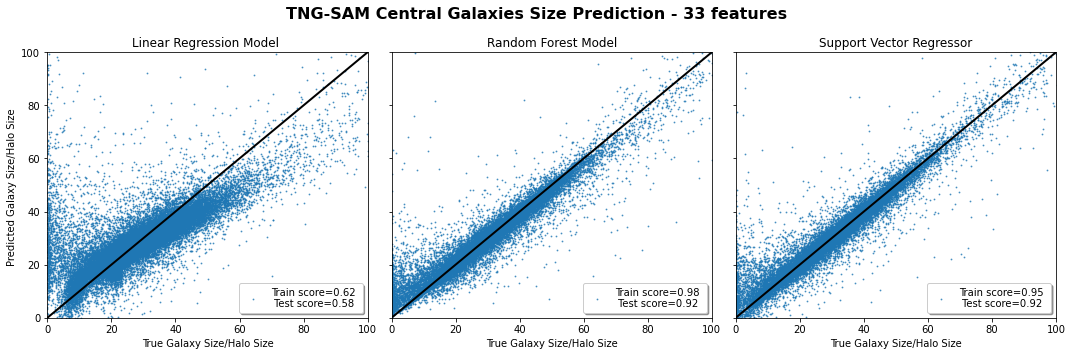

In [83]:
fig,[ax1, ax5, ax6 ]=plt.subplots(nrows=1,ncols=3,sharey=True, figsize=(15,5))
fig.suptitle('TNG-SAM Central Galaxies Size Prediction - 33 features', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = 'Train score={} \n Test score={}'.format(round(reg.score(X_train, y_train), 2),round(reg.score(X_test, y_test), 2) )
# print(label)
im1 = ax1.scatter(y, y_pred_LR, s=3, marker='.', alpha=0.7, label=label)
# ax1.set_xlim([9.0, 11.5])
# ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax1.set_ylim([0.2,1.2])
ax1.axis([0.0,100, 0.0,100])
ax1.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax1.set_title('Linear Regression Model ')
ax1.set_xlabel('True Galaxy Size/Halo Size')
ax1.set_ylabel('Predicted Galaxy Size/Halo Size ')
ax1.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_RF_trainscore, 2),round(scores_RF.mean(), 2) )
im5 = ax5.scatter(y, y_pred_RF, s=3, marker='.', alpha=0.7, label=label)
# ax5.set_xlim([9.0, 11.5])
# ax5.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax5.set_ylim([0.2,1.2])
ax5.axis([0.0,100, 0.0,100])
ax5.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax5.set_title('Random Forest Model')
ax5.set_xlabel('True Galaxy Size/Halo Size')
# ax5.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax5.legend(loc='lower right', shadow=True)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore, 2),round(scores_SVR.mean(), 2) )
im6 = ax6.scatter(y, y_pred_SVR, s=3, marker='.', alpha=0.7, label=label)
# ax6.set_xlim([9.0, 11.5])
# ax6.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
# ax6.set_ylim([0.2,1.2])
ax6.axis([0.0,100, 0.0,100])
ax6.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
ax6.set_title('Support Vector Regressor')
ax6.set_xlabel('True Galaxy Size/Halo Size')
# ax6.set_ylabel('Predicted $ log_{10} $ Galaxy Size  [kpc] ')
ax6.legend(loc='lower right', shadow=True)
    
# grid = plt.GridSpec(3, 2)
# create_subtitle(fig, grid[0, ::], 'Linear Regression with only Stellar Mass as a feature')
# create_subtitle(fig, grid[1, ::], 'Linear Regression with only Halo Mass as a feature')
# create_subtitle(fig, grid[2, ::], 'Linear Regression vs Random Forest Regressor with all features')

# fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.tight_layout()
# plt.savefig("TNG-SAM_LR_RF_SVR_size_prediction_33feat.jpeg", dpi=500)
plt.show()